# Cooking ingredients recommendation
This notebook builds a recommendation system for cooking ingredients using. The end goal is to build a recommendation system that takes as input a list of existing ingredients and outputs a collection of ingredients that would go well with the existing ingredients. 

Contents

0. load and clean data
1. Collaborative filtering
2. Word-embeddings
3. Neural network 
4. Association rule mining





In [2]:
import sys
sys.path.append('/usr/local/lib/python2.7/site-packages/')
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [1]:
import pandas as pd
import numpy as np
import regex as re
import random
import ijson
#import tensorflow as tf
import ast 
import csv

#import mpld3 # for interactive matplotlib 
#from mpld3 import plugins
from sklearn.decomposition import NMF
#from symspellpy.symspellpy import SymSpell
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer #for vectorizing categorial features
from sklearn.decomposition import PCA
#from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, LSTM, Embedding
#from tensorflow.keras.callbacks import CSVLogger
from collections import Counter 
 
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')

import os
import pickle
import h5py
import gensim


# 0. Load & clean data    

<b> (a) Load data </b> 
* While I found some sources for recipe data, I chose to work with the <a href="https://www.kaggle.com/kaggle/recipe-ingredients-dataset/">recipe-ingredients dataset</a> from Kaggle.  
* The dataset was provided as part of a competition for predicting the cuisine type given ingredients list. 
* I chose this dataset because I wanted to ask my recommender system questions like "How do I cook my chicken in Indian style? Korean style?  
* In particular, I used just the training data of this dataset. 
* If one was interested in building a recommender system for ingredients without considering the cuisine, one could use both the training and testing set of the Kaggle dataset. One can also extend the dataset by combining with other sources of recipe data  
* For example, the "recipes" notebook uses a different dataset. Note that that particular dataset requires more involved text cleaning process than the kaggle dataset


<b> (b) Text cleanup </b> 


<b> (c) Preliminary analysis </b>  


<b> (d) Split data into training, cross-validation, and testing set</b> 

<b> (e) Define metrics for evaluating different models </b>


<b> (a) Load data </b>

In [2]:
file_name = 'data/recipe-ingredients-dataset/train.json'

with open(file_name, 'r') as f:
  objects = ijson.items(f, 'item')
  data = list(objects)

df = pd.DataFrame(data)

<b> (b) Clean up text </b>  
* Some issues with the given data:  
    (1) Some ingredients contain additional information given in parentheses. Example: " (2 oz. ) tomato sauce "  
    (2) Some ingredients have upper case letters, while most ingredients are written in lower case letters.  
    (3) Some ingredients contain brand names of the ingredients.  
    (4) Some ingredients contain non-alphabet characters. Many of them seem to come from brand names.   
    (5) Some ingredients contain additional instructions. Example: "spinach, thawed and squeezed dry"  
    
* In this section, I addressed issues (1) and (2) by <b> removing any characters between parentheses, and turning all strings into lowercase letters. </b>      
* I did not address issue (3) because removing brand names would be consuming process with little reward, given there aren't many ingredients containing brand names. One way to do this is to manually go through all ingredients that contain Upper case letters, determine whether they refer to generic ingredients or brand names, and remove brand names accordingly. Note: one would have to complete this step before addressing issue (2).  
* Usually, I would remove non-alphabet characters for NLP tasks. However, since we are not doing any word/ character generation and non-alphabet characters seem to be associated with brand names, I decided that removing the non-alphabet characters wouldn't make much difference. 
* Addressing issue (5) would involve manually going through the data

In [3]:
# let's take a look at the list of ingredients to figure out
# what kind of text cleaning is required

ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')

print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:50])
print(ing_list[-50:])

Example ingredients
['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham'
 '33% less sodium ham' '33% less sodium smoked fully cooked ham'
 '40% less sodium taco seasoning' '40% less sodium taco seasoning mix'
 '7 Up' '8 ounc ziti pasta, cook and drain' '95% lean ground beef'
 'A Taste of Thai Rice Noodles' 'Accent Seasoning'
 'Adobo All Purpose Seasoning' 'Alaskan king crab legs'
 'Alexia Waffle Fries' 'Alfredo sauce' 'Amaren

In [4]:
# Remove characters between (and including) parentheses
# Turn all strings into lowercase

for i in df.index:
    ing = df.at[i,'ingredients']
    for j, item in enumerate(ing):
        # Replace all characters between parentheses
        if  ('(' in item) or (')' in item):
            item = re.sub('\s*\([^)]*\)\s*', '', item)
            ing[j] = item
        
        # Turn all Upper case into lowercase
        ing[j] = item.lower()
        
    df.at[i,'ingredients'] = ing

In [5]:
ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')
  
print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:50])
print(ing_list[-50:])

Example ingredients
['1% low-fat buttermilk' '1% low-fat chocolate milk'
 '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham'
 '33% less sodium ham' '33% less sodium smoked fully cooked ham'
 '40% less sodium taco seasoning' '40% less sodium taco seasoning mix'
 '7 up' '8 ounc ziti pasta, cook and drain' '95% lean ground beef'
 'a taste of thai rice noodles' 'abalone' 'abbamele' 'absinthe'
 'abura age' 'acai juice' 'accent' 'accent seasoning' 'accompaniment'
 'achiote' 'achiote paste' 'achiote powder' 'acini di pepe' 'ackee'
 'acorn squash' 'active dry yeast' 'adobo' 'adobo all purpose seasoning'
 'adobo sauce' 'adobo seasoning' 'adobo style seasoning' 'adzuki beans'
 'agar' 'agar agar flakes' 'agave nectar'

In [161]:
# add cleaned up ingredients + cuisine to dataframe
df['ing_cuisine'] = ingredients
df.to_csv('data/ingredient_recommendation/data.csv')

In [160]:
df.head()

,id,cuisine,ingredients,ing_cuisine
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...","[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...","[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...","[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]","[water, vegetable oil, wheat, salt, indian]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...","[black pepper, shallots, cornflour, cayenne pe..."


<b> (c) Preliminary analysis </b>  

* About 40,000 recipes involving 6700 ingredients  
* Note that some cuisine (like Italian and Mexican cuisine) are more frequently represented than some others (like Russian and brazilian cuisinze).  
    * I should keep in mind <b>the potential bias</b> this creates: Our recommendation system might recommend ingredients that go well together in mostly Italian and Mexican cuisine. 
    *  <b><font color='red'>To Do</font></b>: I might want to consider some tools for decreasing bias from my model. 

In [152]:
ing_list = np.unique([item for recipes in ingredients for item in recipes])

print('total number of recipes: ', len(ingredients))
print('total number of ingredients: ', len(np.unique(ing_list)))

total number of recipes:  39774
total number of ingredients:  6713


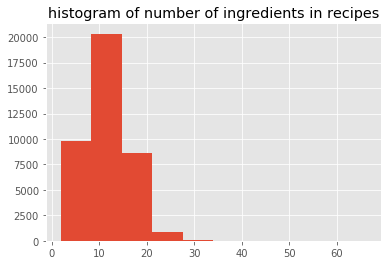

maximum number of ingredients in a given recipe:  66
minimum number of ingredients in a given recipe:  2


In [154]:
# Number of ingredients in each recipe
ing_len = [len(x) for x in ingredients]

plt.hist(ing_len)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

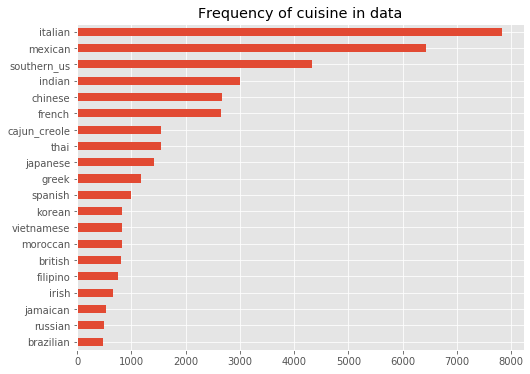

In [156]:
# Number of cuisine represented
cuisine_count = {}
for item in np.unique(cuisine):
    cuisine_count[item] = cuisine.count(item)

df['cuisine'].value_counts(ascending = True).plot(kind = 'barh', figsize=(8,6))
plt.title('Frequency of cuisine in data')
plt.show()

<b> (d) Divide into training, cross-validation, and testing set </b>

In [176]:
# Divide into training (70%), cross-validation (15%), and testing set (15%)
n_recipes = df.shape[0]
print('total number of recipes: ', n_recipes)

total = list(range(n_recipes))
random.shuffle(total)

train_size = int(n_recipes * 0.7)
cv_size = int(n_recipes * 0.15)
train_idx = total[:train_size]
cv_idx = total[train_size:train_size + cv_size]
test_idx = total[train_size + cv_size:]

print('number of training set: ', len(train_idx))
print('number of cross-validation set: ', len(cv_idx))
print('number of test set: ', len(test_idx))

train_idx.sort()
cv_idx.sort()
test_idx.sort()

# save indices
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'w')
f.create_dataset("train_idx", data = train_idx)
f.create_dataset("cv_idx", data = cv_idx)
f.create_dataset("test_idx", data = test_idx)
f.close()

# to load
#f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
#train_idx = list(f.get("train_idx"))
#cv_idx = list(f.get("cv_idx"))
#test_idx = list(f.get("test_idx"))
#f.close()

total number of recipes:  39774
number of training set:  27841
number of cross-validation set:  5966
number of test set:  5967


<b> (e) Define metric for evaluating different models</b>  
* Use evaluation metric for classification models      
* Precision, Recall, and F-scores 
    * Precision: Of all the predicted ingredients, how much were actually true ingredients? TP / (TP + FP)
    * Recall: Of all the true ingredients, how much did we predict correctly? TP/(TP + FN)   
    * F-score : (2 * recall * precision) / (recall + precision)    
    
* Possible option:.igh the incorrect ingredients. For example, if an incorrect predicted ingredient is still considered "similar" to an existing ingredient (maybe using word embedding features), one can still account for the incorrect prediction as a true positive with a smaller weight than 1
  

In [26]:
def compute_scores(predicted_ing, true_ing):
    """
    predicted_ing: (set) of predicted ingredients from the model
    true_ing: (set) of true ingredients that needed to be predicted
    """

    TP = len(predicted_ing.intersection(true_ing))

    precision = TP / (len(predicted_ing))
    recall = TP / len(true_ing)
    F_score = (2 * recall * precision)/(precision + recall)
    
    return precision, recall, F_score


In [27]:
# example 
precision, recall, F_score = compute_scores(set(['onions', 'scallions', 'bread']),
                                           set(['scallions']))

print('precision: ' , precision)
print('recall: ', recall)
print('F_score: ', F_score)

precision:  0.3333333333333333
recall:  1.0
F_score:  0.5


# 1. Collaborative filtering  


<b> Summary </b> 
* Used non-negative matrix factorization.  
* Latent variables (roughly) correspond to type of cuisine, such as baking, Italin food, Mexican food, ... .  
* Built a recommendation system from the matrix factorization.  
* Solution to cold-start problem: Found recipes that are most similar to given list of ingredients. Returned ingredients recommended to these similar recipes.  

<b> To do </b> 
* Cross validation to choose the number of latent factors: It turns out, there is a way to do some form of cross-validation with unsupervised learning models, as shown in this <a href="http://alexhwilliams.info/itsneuronalblog/">blog post</a>   

<b> The idea behind non-negative matrix factorization (NMF) </b>
* Given a matrix V, NMF factorizes V into non-negative matrices W and H such that $ W H \approx V$. 
![From wikipedia](files/images/NMF.png)  


* One can describe each column of V as a linear combination of columns of W. The coefficients of this linear combination is given by the columns of H. 

* Idea: The factorization $ W H \approx V$ learns latent features underlying the interactions beetween recipes and ingredients.

* In this project, consider V as the ingredients-recipe matrix. 
    * Each column of V corresponds to a recipe.  
    * Each row of V corresponds to an ingredient.  
    * V [ i ][ j ] = 1 if ingredient *i* is present in recipe *j*, and 0 otherwise
* Non-negative matrix factorization will attempt to find matrices W and H such that  
$W H \approx V$


<b> Create matrix V </b>  
* columns: recipes  
* rows: ingredients  
* V [ i ][ j ] = 1 if ingredient *i* is present in recipe *j*, and 0 otherwise

In [30]:
# Find all the ingredients
ingredients_total = [item for sublist in ingredients for item in sublist]
ingredients_total = list(set(ingredients_total))

n_ingredients = len(ingredients_total)
n_recipes = len(ingredients)

print('number of ingredients: ', n_ingredients)
print('number of recipes: ', n_recipes)

# Assign row values to each ingredient
ing_dict = {idx:x for idx, x in enumerate(ingredients_total)}
ing_dict_reverse = {value:key for key, value in ing_dict.items()}

# create matrix V
V = np.zeros((n_ingredients, n_recipes))
for i, recipe in enumerate(ingredients):
    for ing in recipe:
        j = ing_dict_reverse[ing]
        V[j,i] = 1

number of ingredients:  6734
number of recipes:  39774


<b> Latent variables </b>  
For fun, let's see what the latent variables represent when we do a matrix factorization with 10 latent variables 

In [ ]:
model = NMF(n_components=10)
W = model.fit_transform(V)
H = model.components_

In [142]:
# For each component return 10 most representative ingredients
for i in range(10):
    indices = np.argsort(W[:,i])[::-1][:10]
    print('***LATENT COMPONENT ' + str(i) + '***')
    for item in indices:
        print(ing_dict[item])

***LATENT COMPONENT 0***
salt
pepper
black pepper
eggs
flour
garlic powder
lemon juice
oil
greek
cooking spray
***LATENT COMPONENT 1***
all-purpose flour
southern_us
butter
sugar
large eggs
baking powder
unsalted butter
milk
eggs
vanilla extract
***LATENT COMPONENT 2***
italian
olive oil
grated parmesan cheese
fresh basil
dry white wine
dried oregano
fresh parsley
flat leaf parsley
extra-virgin olive oil
tomatoes
***LATENT COMPONENT 3***
soy sauce
chinese
sugar
sesame oil
green onions
corn starch
garlic
vegetable oil
scallions
rice vinegar
***LATENT COMPONENT 4***
mexican
ground cumin
chili powder
sour cream
jalapeno chilies
avocado
corn tortillas
salsa
chopped cilantro fresh
black beans
***LATENT COMPONENT 5***
garlic cloves
extra-virgin olive oil
olive oil
onions
cooking spray
fresh lemon juice
red bell pepper
chopped onion
black pepper
carrots
***LATENT COMPONENT 6***
onions
garlic
carrots
olive oil
pepper
green bell pepper
cajun_creole
celery
chicken broth
tomatoes
***LATENT COMPON

Indeed, the latent variables correspond to different types of cuisine.    
For example, latent variable 1 represents ingredients used for baking.  
Latent variable 2 represents ingredients used for Italian food.  
Latent variable 3 represents ingredients used for Chinese food.  
Latent variable 4 represents ingredients used for Mexican food.  

<b> Perform NMF</b>  

In [144]:
model = NMF(n_components=300)
W = model.fit_transform(V)
H = model.components_

#print(model.reconstruction_err_)

In [158]:
f = h5py.File("models/NMF/NMF_300.hdf5", "w")
f.create_dataset('V', data = V)
f.create_dataset('W', data = W)
f.create_dataset('H', data = H)
f.close()

<b> Perform recommendation </b>  
* One of the problems with collaborative filtering is the cold-start problem.  
* In this project, the most relevant cold-start problem is when a new user is added.  When a new user comes with a few existing ingredients and ask for recommendations, there are two problems to address:   
    (1) How to provide a recommendation to the user?   
    (2) How to update the matrix factorization, without having to redo the entire factorization all over again?  
    
In this section, I'm mostly concerned with problem (1). There are some active research going on regarding online updating of matrix factorizations to address problem (2).   

While there are multiple tactics for addressing new user problems, I chose to find other users/ recipes that are similar to the new user. I then used the factorized matrices to recommend ingredients 

<b> Recommendation to an existing recipe </b>

In [167]:
f = h5py.File('models/NMF/NMF_300.hdf5', 'r')
V = np.array(f.get('V'))
W = np.array(f.get('W'))
H = np.array(f.get('H'))
f.close()

V_approx =np.matmul(W,H)

In [168]:
# Let's compare the recommendations to existing recipes 
recipe_num = 20

print("*** EXISTING INGREDIENTS ***")
for item in ingredients[recipe_num]:
    print(item)
    
# print the top 20 recommended ingredients

print("*** RECOMMENDED INGREDIENTS ***")
recommend = np.argsort(V_approx[:,recipe_num])[::-1]
for item in recommend[:20]:
    print(ing_dict[item])

*** EXISTING INGREDIENTS ***
pork loin
roasted peanuts
chopped cilantro fresh
hoisin sauce
creamy peanut butter
chopped fresh mint
thai basil
rice
medium shrimp
water
rice noodles
beansprouts
thai
*** RECOMMENDED INGREDIENTS ***
thai
water
chopped cilantro fresh
rice
medium shrimp
beansprouts
chopped fresh mint
hoisin sauce
peanuts
rice noodles
chinese five-spice powder
lemongrass
roasted peanuts
unsweetened coconut milk
rice vermicelli
Thai fish sauce
Thai red curry paste
ground lamb
creamy peanut butter
english cucumber


<b> Recommendation to a new user </b>  

For example, let's say a new user joins. The new user knows that he wants to cook some Korean style chicken, and he knows he wants to use chicken, sesame seeds, and scallions. 


In [169]:
# new user with existing ingredients and preferred cuisine style
user_ing = ['korean', 'chicken', 'sesame seeds', 'scallions']

# define new user vector
new_user = np.zeros((n_ingredients,1))
for item in user_ing:
    idx = ing_dict_reverse[item]
    new_user[idx, 0] = 1

Compute cosine similarity between new user vector and all recipes

In [170]:
# compute dot product between new user and recipes
sim = np.matmul(V.T, new_user)

# compute magnitude of each recipe vector and new user vector
norm_recipes = np.sqrt(np.sum(np.square(V), axis = 0))
norm_user = np.sqrt(np.sum(np.square(new_user)))

# find the normalizing factor for each recipe
norm = np.reciprocal((norm_recipes * norm_user).reshape(-1,1))

# compute cosine similarity
cosine_similarity = np.multiply(sim, norm).flatten()

* Find 10 most similar recipes. 
* Collect 10 recommended ingredients for each recipes. 
* From the collection of recommended ingredients, return ingredients from most frequently recommended to least frequently recommended

In [171]:
# sort based on similarity score 
sim_sort = np.argsort(cosine_similarity)

# Find recommended ingredients
recommend = [] 

# Find 10 most similar recipes
for item in sim_sort[-10:]:
    rec = np.argsort(V_approx[:,item])
    
    # Find 10 ingredients to recommend
    for i in rec[-10:]:
        recommend.append(ing_dict[i])

In [172]:
# sort the recommended ingredients according to frequency of recommendation
sorted_rec = sorted(recommend ,key=recommend.count, reverse = True)
rec = [] 

for item in sorted_rec:
    if (item not in rec) and (item not in user_ing):
        rec.append(item)

# print 10 ingredients to recommend
print("Recommended ingredients: ")
for i in range(10):
    print(rec[i])
        


Recommended ingredients: 
Gochujang base
kimchi
soy sauce
sesame oil
rice wine
vegetable oil
garlic cloves
water
napa cabbage
chopped garlic


# 2. Word embeddings  
(a) Word2Vec   
(b) GloVe  

<b> Why word embeddings? </b>  
I thought that the word analogies of word embeddings would be useful in understanding questions like "what vegetable would go well with lamb?". I was also inspired by other data scientists who used word embeddings for context-dependent recommenders. (Examples: <a href="https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484">music recommendation</a>, <a href="https://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/">stitch fix</a>, <a href="https://www.nature.com/articles/s41586-019-1335-8">material science</a>, and <a href="http://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/"> many others </a>)

I investigated two possibilities with word embeddings. 
 
1. Can word analogies be useful in understanding questions like "what vegetable would go well with lamb?"  
2. What is the relationship between ingredients that have similar vector representations? Are they substitutes? complementary? Depending on the answer to this question, I can then attempt to build a recommendation system from word embeddings

In this section, I investigate the above two questions for Word2Vec and GloVe embeddings.  
* I started with Word2Vec because more familiar with the model.  
* However, for this particular project, I realized that GloVe may be better suited for this project.

Some explanation for why I studied GloVe as well:

Note that Word2Vec extracts embeddings from a neural network designed to perform a surrogate task. In the continuous-bag-of-words (CBOW) model, the surrogate tasks is to predict a word given the surrounding context words. The size of this context can be defined by the user. I wanted to remove this dependence on the size of the context because of the following reason:

Say we have a recipe with 10 ingredients:[i0, i1, i2, ... , i9] 
If we chose a context size of 2 words to the left and right, then the surrogate task would attemt to solve the following task:
    * From ingredients (i0, i1, i3, i4), predict i2
    * From ingredients (i1, i2, i4, i5), predict i3, and so on.
Thus, according to the model, ingredient i9 does not appear in the context of i0. However, we do want all ingredients belonging to the same recipe to be considered as being in the same context.  

There are ways to work around this. (1) We can permute the order of ingredients in each recipe, and hope that we have a large enough training set. (2) We could also add to the training set some different permutations of the ingredients. (3) We could use GloVe.

GloVe learns word embeddings based on the co-occurrence count of words. In this case, any two ingredients that appear together in the same recipe will be considered as co-occuring words. 





# word embeddings : word2vec 
* Using pre-trained word2vec embedding
* Using our own training on recipe data
* Training the neural network (and not just the embedding) 
* look at the section that exists in the LSTM section

## pre-trained word2vec model
* Let's use the pre-trained word2vec model from the <a href="https://code.google.com/archive/p/word2vec/">Google News dataset</a>
* The model contains 300-dimensional vectors for 3 million words and phrases  
* You should download the pre-trained model in the <a href="https://code.google.com/archive/p/word2vec/">Google Code Archive</a>

In [3]:
# load pre-trained word2vec model
path_googlenews = 'data/word2vec/GoogleNews-vectors-negative300.bin'
pretrained_word2vec= gensim.models.KeyedVectors.load_word2vec_format(path_googlenews, binary=True) 

/usr/local/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [5]:
pretrained_word2vec.similar_by_word('steak',topn=15,restrict_vocab=None)

[('steaks', 0.7992713451385498),
 ('filet_mignon', 0.7782121896743774),
 ('porterhouse', 0.7527751922607422),
 ('sirloin', 0.7395126819610596),
 ('prime_rib', 0.7364764213562012),
 ('filet', 0.7349370718002319),
 ('porterhouse_steak', 0.7305288314819336),
 ('tenderloin', 0.7280069589614868),
 ('roast_beef', 0.7186790108680725),
 ('rib_eye', 0.7158585786819458),
 ('ribeye_steak', 0.7071082592010498),
 ('sirloin_steak', 0.7050917744636536),
 ('ribeye', 0.701675295829773),
 ('hanger_steak', 0.6981855630874634),
 ('striploin', 0.6928503513336182)]

In [ ]:
pretrained_word2vec.similar_by_word('salad',topn=15,restrict_vocab=None)

* While the pre-trained model has the advantage of easy use, it takes a long time to load the model and to query the embedding. 
* It probably takes a long time because of the huge number of vocabulary.
* Since we are only concerned with ingredients, it may be faster to train a model ourselves using just the words we are concerned with. 


## Train a word2vec model

In [3]:
# train word2vec
embedding_dim=300
model=gensim.models.Word2Vec(ingredients, size=embedding_dim, window=30, min_count=0)

In [4]:
model.wv.most_similar('steak',topn=15,restrict_vocab=None)

[('pork chops', 0.9173249006271362),
 ('chili pepper flakes', 0.9021896123886108),
 ('soup', 0.8890161514282227),
 ('shrimp shells', 0.8835002779960632),
 ("Frank'sÂ® RedHotÂ® Original Cayenne Pepper Sauce", 0.8797524571418762),
 ('mixed vegetables', 0.8683021068572998),
 ('sauce', 0.86557537317276),
 ('fish balls', 0.8647212982177734),
 ("tony chachere's seasoning", 0.8566193580627441),
 ('cabbage leaves', 0.8564741611480713),
 ('frozen broccoli florets', 0.8563554286956787),
 ('kinchay', 0.8525336980819702),
 ('buns', 0.8517208695411682),
 ('boneless chicken breast', 0.8515726923942566),
 ('chuno sauce', 0.8510098457336426)]

In [24]:
model.wv.most_similar('chicken', topn = 15)

[('basmati', 0.8501617908477783),
 ('homemade stock', 0.8499741554260254),
 ('red kidney beans', 0.8388198614120483),
 ('spices', 0.8258204460144043),
 ('rice', 0.8199082016944885),
 ('hot pepper', 0.8172221183776855),
 ('pork shoulder', 0.8009617328643799),
 ('imitation seafood', 0.8001091480255127),
 ('chicken thighs', 0.7935663461685181),
 ('bay leaves', 0.7888513207435608),
 ('meat', 0.7874410152435303),
 ('chicken stock', 0.7855333089828491),
 ('sablefish', 0.7811201810836792),
 ('bell pepper', 0.778683066368103),
 ('chuck', 0.7778372764587402)]

<b> Word analogies </b> 
* Let's say I'm cooking lamb, and I want to know what vegetable would go well with lamb. 
* I can use known protein-vegetable pairings, such as steak & asparagus, to ask the word embedding to solve the following word analogy problem  
    <b>steak</b> is to <b>asparagus</b> as <b>lamb</b> is to <b>?</b>   
    i.e., steak : asparagus = lamb : ?  
* That is, we want to find the ingredient that best satisfies the following:  
    wv['asparagus']-wv['steak'] = wv[?] - wv['lamb'], or
    wv[?] = wv['lamb'] + wv['asparagus'] - wv['steak']
    

In [23]:
model.wv.similar_by_vector(model.wv['lamb']+model.wv['asparagus']-model.wv['steak'],restrict_vocab=None)

[('yellow crookneck squash', 0.9291372299194336),
 ('fennel bulb', 0.9225113391876221),
 ('fennel', 0.9141095876693726),
 ('nonfat chicken broth', 0.8998813033103943),
 ('asparagus', 0.8944079875946045),
 ('Italian parsley leaves', 0.8843654990196228),
 ('florets', 0.873955488204956),
 ('striped bass', 0.8687739968299866),
 ('fresh rosemary', 0.8651928901672363),
 ('hot red pepper flakes', 0.8642042875289917)]

<b> Cooking in style </b>  
* What if I wanted to cook a particular ingredient in a particular cuisine?  
* For example, if I wished to cook chicken in an Indian style cuisine, what other ingredients would go well?

In [27]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['indian'],topn=15)


[('indian', 0.9673752784729004),
 ('garam masala', 0.927364706993103),
 ('ground turmeric', 0.9177412986755371),
 ('tumeric', 0.9012154340744019),
 ('cumin seed', 0.8709600567817688),
 ('basmati rice', 0.8704847097396851),
 ('mild curry powder', 0.8595356941223145),
 ('calabash', 0.856178343296051),
 ('ground tumeric', 0.8478215932846069),
 ('yoghurt', 0.8407273292541504),
 ('curry leaves', 0.8394922614097595),
 ('fenugreek', 0.839362621307373),
 ('mustard seeds', 0.835870087146759),
 ('yellow split peas', 0.833548903465271),
 ('black mustard seeds', 0.8307055830955505)]

<b>Recommending new ingredients from existing ingredients </b>  
* For example, let's say I want to cook my chicken in Korean style, and I have the following ingredients: chicken, onions, sesame seeds.  
* Can the model recommend some other ingredients that would go well?  

In [28]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['korean']
                           + model.wv['onions'] + model.wv['sesame seeds'],topn=15)

[('other vegetables', 0.8722476363182068),
 ('Gochujang base', 0.8670608997344971),
 ('sesame oil', 0.854427695274353),
 ('rice wine', 0.8444992899894714),
 ('Korean chile flakes', 0.8362123966217041),
 ('bean sauce', 0.8357012271881104),
 ('ramen noodles', 0.8195841312408447),
 ('marinade', 0.8191328048706055),
 ('soybean paste', 0.8187799453735352),
 ('bean paste', 0.818573534488678),
 ('gochugaru', 0.816921055316925),
 ('kimchi', 0.814910888671875),
 ('korean', 0.811623215675354),
 ('toasted sesame seeds', 0.8076875805854797),
 ('fried eggs', 0.8049585819244385)]

* 'Other vegetables' is good for our diet but really not helpful right now..  
* The other recommendations do seem helpful and in line with Korean style cuisine


# word embeddings using GloVe  
* Similar to word2vec, but based on a co-occurence statistics  
* Had to use these on my mac  
* Note: training GloVe isn't done in this notebook
* This section simply prepares the text for training and analyzes the result 
* Does GloVe depend on how close the words are? Or is it just about co-occurrence in the same document? 

In [29]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

<b> Prepare text for training GloVe</b> 
* According to <a href="https://github.com/stanfordnlp/GloVe/tree/master/src">GloVe README file</a>, we should prepare our text file according to the following. 
    * Prepare corpus as a single text file
    * Words should  be separated by one or more spaces or tabs
    * Multiple documents should be separated by new line characters. Cooccurrence contexts for words do not extend past newline characters

In [5]:
# print current format
print(ing_cuisine[:10])

[['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles', 'greek'], ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil', 'southern_us'], ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken livers', 'filipino'], ['water', 'vegetable oil', 'wheat', 'salt', 'indian'], ['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'butter', 'salt', 'lemon juice', 'water', 'chili powder', 'passata', 'oil', 'ground cumin', 'boneless chicken skinless thigh', 'garam masala', 'double cream', 'natural yogurt', 'bay leaf', 'indian'], ['plain flour', 'sugar', 'butter', 'eggs', 'fresh ginger root', 'salt', 'ground cinnamon', 'milk', 'vanilla extract', 'ground ginger', 'p

In [21]:
# In Glove, spaces are used to separate words.
# Ingredients that involve spaces should be adjusted

# for each recipe, replace spaces with underscore, and join all ingredients into one string
glove_training = []

for recipe in ing_cuisine:
    # replace spaces in ingredients with underscore
    recipe_new = [item.replace(' ','_') for item in recipe]
    
    # join ingredients into a string and add newline character 
    glove_training.append(' '.join(recipe_new)+'\n')

In [22]:
glove_training

['romaine_lettuce black_olives grape_tomatoes garlic pepper purple_onion seasoning garbanzo_beans feta_cheese_crumbles greek\n',
 'plain_flour ground_pepper salt tomatoes ground_black_pepper thyme eggs green_tomatoes yellow_corn_meal milk vegetable_oil southern_us\n',
 'eggs pepper salt mayonaise cooking_oil green_chilies grilled_chicken_breasts garlic_powder yellow_onion soy_sauce butter chicken_livers filipino\n',
 'water vegetable_oil wheat salt indian\n',
 'black_pepper shallots cornflour cayenne_pepper onions garlic_paste milk butter salt lemon_juice water chili_powder passata oil ground_cumin boneless_chicken_skinless_thigh garam_masala double_cream natural_yogurt bay_leaf indian\n',
 'plain_flour sugar butter eggs fresh_ginger_root salt ground_cinnamon milk vanilla_extract ground_ginger powdered_sugar baking_powder jamaican\n',
 'olive_oil salt medium_shrimp pepper garlic chopped_cilantro jalapeno_chilies flat_leaf_parsley skirt_steak white_vinegar sea_salt bay_leaf chorizo_saus

In [23]:
f = open("model/glove/glove_training.txt", "w")
f.writelines(glove_training)
f.close()

In [28]:
# Double check that we have the correct file format
# the following should give ingredients of the first two cuisine
#f = open('data/glove/glove_training.txt','r')
#print(f.readline())
#print(f.readline())
#f.close()

romaine_lettuce black_olives grape_tomatoes garlic pepper purple_onion seasoning garbanzo_beans feta_cheese_crumbles greek

plain_flour ground_pepper salt tomatoes ground_black_pepper thyme eggs green_tomatoes yellow_corn_meal milk vegetable_oil southern_us



<b> Training on GloVe </b>  
* Clone <a href="https://github.com/stanfordnlp/GloVe">GloVe repository</a> 
* Run "make" 
* Copy the "glove_training.txt" file to the glove directory 
* Edit the "demo.sh" file:
    * Remove the 9 lines after "make" starting with "if" and ending with "fi"  
    * Edit right side of "CORPUS=" with file name "glove_training.txt"  
* Run "./demo.sh" 
* The word vectors will be saved in the "vectors.txt" file. 

<b> GloVe results </b>  
* Vocab size: 3357
* Vector size: 50
* Cost: 0.0325



In [ ]:
# Note: GloVe returns the statistics of co-occurrence and the word embeddings
# it doesn't return a model like word2vec that can be used to predict surrounding words
# Just have to do the best with the embeddings themselves

In [30]:
# convert GloVe vector text format into word2vec text format
# This way, we can use gensim to do word comparisons and analysis
glove2word2vec(glove_input_file="model/glove/glove_vectors.txt", 
               word2vec_output_file="model/glove/gensim_glove_vectors.txt")

/usr/local/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(3358, 50)

In [32]:
glove_model = KeyedVectors.load_word2vec_format("model/glove/gensim_glove_vectors.txt", binary=False)

In [35]:
glove_model.most_similar('steak',topn=15,restrict_vocab=None)

[('cod', 0.6614221930503845),
 ('panko_breadcrumbs', 0.6294422149658203),
 ('pork_chops', 0.5919418334960938),
 ('tonkatsu_sauce', 0.5722765922546387),
 ('beaten_eggs', 0.5602886080741882),
 ('flour', 0.5539854764938354),
 ('frozen_peas_and_carrots', 0.49084463715553284),
 ('min', 0.4804944396018982),
 ('panko', 0.4743003249168396),
 ('chives', 0.4698525071144104),
 ('sweet_chili_sauce', 0.4662887454032898),
 ('ramen_noodles', 0.45906150341033936),
 ('ground_chicken', 0.44420695304870605),
 ('Chinese_rice_vinegar', 0.4360998868942261),
 ('chorizo', 0.43559232354164124)]

In [39]:
glove_model.most_similar('chicken',topn=15,restrict_vocab=None)

[('garlic', 0.7296680808067322),
 ('onions', 0.6966990232467651),
 ('chicken_stock', 0.6510413885116577),
 ('chicken_broth', 0.6387048363685608),
 ('chicken_breasts', 0.626524806022644),
 ('sauce', 0.6245228052139282),
 ('pepper', 0.620618462562561),
 ('yellow_onion', 0.614948570728302),
 ('spices', 0.6102616190910339),
 ('rice', 0.6061379909515381),
 ('bay_leaves', 0.6036665439605713),
 ('cilantro', 0.6028690338134766),
 ('tomatoes', 0.6022893190383911),
 ('kosher_salt', 0.5862119197845459),
 ('bay_leaf', 0.5841464400291443)]

In [37]:
glove_model.similar_by_vector(glove_model['lamb'] + glove_model['asparagus']- glove_model['steak'],topn=15,restrict_vocab=None)


[('couscous', 0.6679390668869019),
 ('asparagus', 0.6486406326293945),
 ('spinach_leaves', 0.6287509799003601),
 ('tahini', 0.62239009141922),
 ('garbanzo_beans', 0.5981909036636353),
 ('fresh_lemon_juice', 0.5812668800354004),
 ('chickpeas', 0.5755916833877563),
 ('pinenuts', 0.5707820653915405),
 ('lemon_zest', 0.5574780702590942),
 ('orzo', 0.5545808672904968),
 ('grated_lemon_peel', 0.5538576245307922),
 ('lamb', 0.5468550324440002),
 ('chopped_fresh_mint', 0.542788565158844),
 ('preserved_lemon', 0.5352820158004761),
 ('arborio_rice', 0.5287206768989563)]

In [38]:
glove_model.similar_by_vector(glove_model['chicken'] + glove_model['korean'],topn=15)

[('korean', 0.8404902219772339),
 ('toasted_sesame_seeds', 0.7193809747695923),
 ('sesame_seeds', 0.713943362236023),
 ('Gochujang_base', 0.7067477703094482),
 ('sesame_oil', 0.702775239944458),
 ('soy_sauce', 0.6895512342453003),
 ('asian_pear', 0.67808997631073),
 ('kimchi', 0.6725336313247681),
 ('beef', 0.6577582955360413),
 ('green_onions', 0.655651330947876),
 ('ginger', 0.642991304397583),
 ('rice_wine', 0.6344742774963379),
 ('sauce', 0.6225952506065369),
 ('chicken', 0.6196356415748596),
 ('noodles', 0.6129593849182129)]

## Training GloVe
* In my experience, using glove_python was easy in Google Colab
* Had trouble installing glove_python on my mac and windows machines 
* The following shows how one might traing GloVe using glove_python. 

In [0]:
# gloVe? 
!pip install glove_python
import glove

In [0]:
#importing the glove library
from glove import Corpus, Glove
# creating a corpus object
corpus = Corpus() 
#training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(ing_cuisine, window=30)


In [0]:
#creating a Glove object which will use the matrix created in the above lines to create embeddings
#We can set the learning rate as it uses Gradient Descent and number of components
glove = Glove(no_components=300, learning_rate=0.05)
 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
#glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [0]:
glove.most_similar('chicken')

[('chicken thighs', 0.7660484469267349),
 ('yellow onion', 0.7660420579410594),
 ('chicken stock', 0.7501534693797555),
 ('sauce', 0.732409851584895)]

In [0]:
glove.most_similar('lamb')

[('lentils', 0.7088676340805032),
 ('lamb shoulder', 0.7057364961743225),
 ('garbanzo beans', 0.6999266932307425),
 ('ras el hanout', 0.6918884404657374)]

In [0]:
glove.most_similar('asparagus')

[('cremini mushrooms', 0.8375173259536696),
 ('linguine', 0.8119749181554341),
 ('pancetta', 0.8101177466581373),
 ('fresh rosemary', 0.7969401439680329)]

In [0]:
# word analogy 

# get embedded vector of a word
def get_vector(word):
  idx = glove.dictionary[word]
  return glove.word_vectors[idx]

In [0]:
v = get_vector('chicken') + get_vector('korean')

In [0]:
# find the word with minimum distance to a given vector 

def closest_words(vector, n):
  # find n-number of words that are closest to given vector 

  # compute distance^2 
  d= np.square(glove.word_vectors - v).sum(axis = 1) 
  indices = np.argsort(d)[:n]

  return [glove.inverse_dictionary[idx] for idx in indices]

In [0]:
closest_words(v, 5)

['korean', 'sesame oil', 'scallions', 'toasted sesame seeds', 'sesame seeds']

In [0]:
#glove.save(directory + '/glove.model')

# Problem with using word embeddings for recommendations  
* Given a word, the most similar words are sometimes
    * substitutes and similar ingredients
    * complementary ingredients
* For example, when we ask for the closest ingredient to "chicken" (using the GloVe model), we get: garlic, onions, chicken stock, chicken broth, chicken breasts, sauce, pepper, .... 
    * While garlic and onions are considered good complementary ingredients, ingredients like chicken stock, chicken broth, chicken breasts similar items that we do not necessarily need. 
* We only want "complementary ingredients". 

# Association rule mining

In [0]:
!pip install efficient-apriori

In [6]:
from efficient_apriori import apriori

ModuleNotFoundError: No module named 'efficient_apriori'

In [0]:
# change data format for apriori algorithm 
ing_list = [tuple(item) for item in ing_cuisine]

<b> minimum support, minimum confidence </b>  
* Apriori algorithm requires the user to specify minimum support and minimum confidence  
* Try to get an idea of the support of ingredients   
* Try to get an idea of the confidence 

In [0]:
# get the list of ingredients
ingredients = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

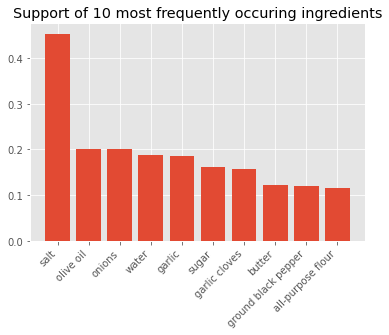

In [0]:
#plot the support of 10 most frequently occurring ingredients
plt.bar(ing_by_count[:10], [ing_count[item]/len(ing_list) for item in ing_by_count[:10]])
plt.xticks(list(range(10)), ing_by_count[:10], ha = 'right', rotation=45)
plt.title('Support of 10 most frequently occuring ingredients')
plt.show()

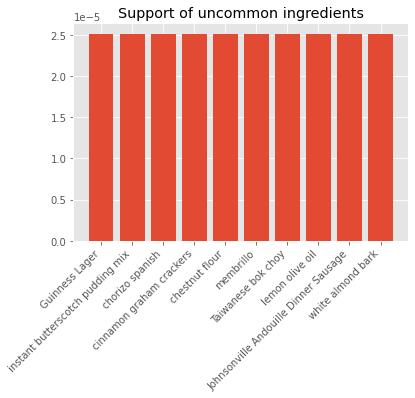

In [0]:
#plot the 10 most rarely occurring ingredients
# use support, instead of frequency 
plt.bar(ing_by_count[-10:], [ing_count[item]/len(ing_list) for item in ing_by_count[-10:]])
plt.xticks(list(range(10)), ing_by_count[-10:], ha = 'right', rotation=45)
plt.title('Support of uncommon ingredients')
plt.show()

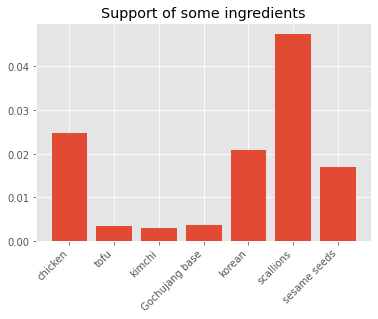

In [0]:
# support of ingredients that I think should be included

my_ingredients = ['chicken','tofu','kimchi', 'Gochujang base', 'korean', 'scallions', 'sesame seeds']
plt.bar(my_ingredients, [ing_count[item]/len(ing_list) for item in my_ingredients])
plt.xticks(list(range(len(my_ingredients))), my_ingredients, ha = 'right', rotation=45)
plt.title('Support of some ingredients')
plt.show()

In [0]:
# what are some ingredients whose support value is around 0.01? 0.005? 0.001?
support = 0.001
freq = support * len(ing_list)
ingredients_support = [item for item in ing_by_count if ing_count[item] <= freq + 10 and ing_count[item] >= freq -10 ]
print(ingredients_support)

['organic vegetable broth', 'salad greens', 'file powder', 'rocket leaves', 'ground round', 'cod fillets', 'colby jack cheese', 'pitted date', 'tapioca flour', 'frozen spinach', 'green bell pepper, slice', 'plain whole-milk yogurt', 'duck', 'softened butter', 'low-fat plain yogurt', 'dried tarragon leaves', 'cooked turkey', 'Alfredo sauce', 'brewed coffee', 'hot Italian sausages', 'lamb shanks', 'country ham', 'broccoli rabe', 'udon', 'rice stick noodles', 'enokitake', 'currant', 'diced red onions', 'spanish onion', 'soft tofu', 'pitted black olives', 'pumpkin seeds', 'ladyfingers', 'ground chuck', 'miso', 'yellow mustard', 'pitas', 'baby arugula', 'chopped almonds', 'olive oil flavored cooking spray', 'lime leaves', 'chicken stock cubes', 'country bread', 'light cream', 'shredded swiss cheese', 'pastry', 'cherries', 'scotch bonnet chile', 'fresh sage', 'roast red peppers, drain', 'white sandwich bread', 'dried chile', 'green curry paste', 'rib eye steaks', 'black sesame seeds', 'beef 

<b> Use apriori algorithm to learn the rules </b>

In [0]:
#itemsets, rules = apriori(ing_list, min_support=0.001, min_confidence=0.3)
#with open(directory + "/rules.txt", "wb") as fp:
#  pickle.dump(rules, fp)

with open(directory + "/rules.txt", "rb") as fp:
  rules = pickle.load(fp)

In [0]:
len(rules)

74459

In [0]:
# This makes me think that "salt" plays the role of "a" and "the" when we do text mining
# might have to remove these... or maybe its okay. We'll see 
# I think this is why its important to consider "lift" as well 
# If salt just appears in every single ingredient, {} -> {salt} will have a high confidence value
# but low lift

In [0]:
def get_rules(rules, query):
  # Find all rules starting with a particular left hand side

  # query must have the format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
  # note that some rules will have multiple items in the right hand side. For simplicity, lets just
  # use rules that return one value 
  query_rules = [item for item in rules if set(item.lhs) == set(query)]
  
  # sorted ccording to decreasing lift values 
  query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
  return query_rules

In [0]:
query = ('Gochujang base',)
query_rules = get_rules(rules, query)
for item in query_rules:
  print(item)

{Gochujang base} -> {korean, onions} (conf: 0.338, supp: 0.001, lift: 64.638, conv: 1.503)
{Gochujang base} -> {korean, soy sauce} (conf: 0.556, supp: 0.002, lift: 51.822, conv: 2.230)
{Gochujang base} -> {korean, sesame oil} (conf: 0.521, supp: 0.002, lift: 51.432, conv: 2.067)
{Gochujang base} -> {garlic, korean} (conf: 0.373, supp: 0.001, lift: 48.994, conv: 1.583)
{Gochujang base} -> {korean, sesame oil, soy sauce} (conf: 0.345, supp: 0.001, lift: 48.670, conv: 1.516)
{Gochujang base} -> {green onions, korean} (conf: 0.352, supp: 0.001, lift: 47.798, conv: 1.532)
{Gochujang base} -> {korean} (conf: 0.958, supp: 0.003, lift: 45.896, conv: 23.173)
{Gochujang base} -> {sesame oil, soy sauce} (conf: 0.366, supp: 0.001, lift: 12.981, conv: 1.533)
{Gochujang base} -> {sesame oil} (conf: 0.542, supp: 0.002, lift: 12.164, conv: 2.087)
{Gochujang base} -> {soy sauce} (conf: 0.592, supp: 0.002, lift: 7.138, conv: 2.245)
{Gochujang base} -> {green onions} (conf: 0.352, supp: 0.001, lift: 4.55

In [0]:
query = ('chicken','soy sauce')
query_rules = get_rules(rules, query)
for item in query_rules:
  print(item)

{chicken, soy sauce} -> {chinese} (conf: 0.372, supp: 0.001, lift: 5.534, conv: 1.485)
{chicken, soy sauce} -> {garlic} (conf: 0.405, supp: 0.001, lift: 2.182, conv: 1.369)
{chicken, soy sauce} -> {water} (conf: 0.331, supp: 0.001, lift: 1.763, conv: 1.214)
{chicken, soy sauce} -> {salt} (conf: 0.479, supp: 0.001, lift: 1.056, conv: 1.049)


In [0]:
# maybe I should include the cuisine 

# How would this work? 
# input ingredients
# find the rules that have highest confidence? lift? 


# What should I do if the input ingredient doesn't appear exactly in the rules? 
# Consider subsets of the ingredient to use as query 

In [0]:
# So this query works only if the query itself is a list of ingredients whose support is 
# greater than the minimum threshold
# Note that this might not be the case for many ingredients

# In that case, in each round of suggestions, we should look for the greatest subset 
# of given ingredients whose support is greater than the minimum threshold, add ingredients


In [0]:
from itertools import combinations

In [0]:
rules_lhs = {item.lhs for item in rules}

In [0]:
ing_tuple = ('chicken', 'korean',)
comb_options = combinations(list(ing_tuple), 1)
for item in comb_options:
  if item in rules_lhs:
    print(item)
    query_rules = get_rules(rules, item)
    recommendation = query_rules[0].rhs
    for ing in recommendation:
      if ing not in ing_tuple:
        print('recommended ingredient: ', ing)

('chicken',)
recommended ingredient:  onions
('korean',)
recommended ingredient:  sesame oil
recommended ingredient:  soy sauce


In [0]:
def recommend(list_ing, list_old, rules_lhs):
  # list_ing: (list) of ingredients
  # list_old: (list) of "old " ingredients
  n_ing = len(list_ing)
  current_list = list_ing.copy()
  new_ing = []

  for i in range(n_ing,0, -1):
    comb_options = combinations(list_ing,i)
    # make sure the combination options don't consist entirely of "prev_tuple",
    # which is something that has already been investigate 

    for item in comb_options:
      if set(item).issubset(set(list_old)) == False:

        if item in rules_lhs:
          query_rules = get_rules(rules, item)
          recommendation = query_rules[0].rhs
          for ing in recommendation:
            if ing not in current_list:
              current_list.append(ing)
              new_ing.append(ing)
  return new_ing
    

In [0]:
def make_recommendations(list_ing, rules_lhs):
  # make recommendations using the function "recommend"
  # until there are a total of 10 ingredients 
  # or until the "recommend" function no longer suggest any recommendations
  # whichever comes first

  list_old = []
  while len(list_ing) <= 15:
    new_ing = recommend(list_ing, list_old, rules_lhs)
    list_old = list_ing.copy()
    list_ing += new_ing
    if new_ing == []:
      break

  return list_ing


In [0]:
make_recommendations(list_ing, rules_lhs)

['chicken',
 'korean',
 'onions',
 'sesame oil',
 'soy sauce',
 'sugar',
 'sesame seeds',
 'garlic',
 'chinese',
 'green onions',
 'salt',
 'pepper']

# Train a Continuous-Bag-Of-Words model using word2vec  
* Instead of using the embeddings, let's use the trained model to predict ingredients  
* While you can train a vanila neural network, we'll use the Word2Vec model provided by gensim since it is extremely easy to use  
* I was concerned about the order of the words.
    * The model itself isn't concerned with the order of words appearing in the neighborhood. 
    * A list of ingredients ofr a recipes should be best considered as an unordered set. 
    * However, this means that not all neighbor relations (that should be represented) won't exist

In [6]:
from gensim.models import Word2Vec

Decide on the appropriate window size

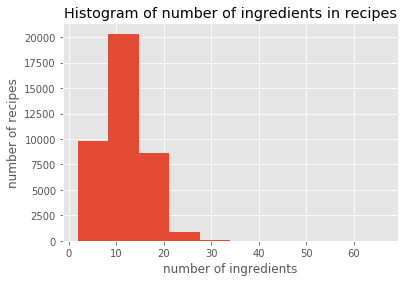

maximum number of ingredients: 66
minimum number of ingredients: 2


In [7]:
# what is the appropriate window size?
ing_length = [len(item) for item in ing_cuisine]
plt.hist(ing_length)
plt.title('Histogram of number of ingredients in recipes')
plt.xlabel('number of ingredients')
plt.ylabel('number of recipes')
plt.show()

print('maximum number of ingredients:', max(ing_length))
print('minimum number of ingredients:', min(ing_length))

In [8]:
# train model
# Note: by default, the model will learn a CBOW model
model = Word2Vec(ing_cuisine, window = 5)


In [ ]:
model

In [13]:
model.predict_output_word(['korean','chicken'])

[('scallions', 0.005289411),
 ('ginger', 0.0052532563),
 ('rice wine', 0.0051988484),
 ('cabbage', 0.004486255),
 ('oyster sauce', 0.004095106),
 ('sesame oil', 0.0040048547),
 ('mirin', 0.003963556),
 ('Gochujang base', 0.0037827776),
 ('oil', 0.0037825126),
 ('cornflour', 0.0037674608)]

# Max entropy model

In [0]:
!pip install maxentropy

     |████████████████████████████████| 51kB 2.5MB/s 
  Created wheel for maxentropy: filename=maxentropy-0.3.0-cp36-none-any.whl size=58406 sha256=98ec5f7cc70f34e5e5d19a7dd8b13261071346f1fc5f874302299e4d01e13415
  Stored in directory: /root/.cache/pip/wheels/95/54/28/e8a73ad1705a1737338bed0c61213946f7bfe702aef1350df3
Successfully built maxentropy


In [0]:
import maxentropy

In [0]:
def f0(x):
    return x in samplespace

def f1(x):
    return x=='dans' or x=='en'

def f2(x):
    return x=='dans' or x=='à'

In [0]:
features = [f0, f1, f2]

samplespace = ['dans', 'en', 'à', 'au cours de', 'pendant']

# Now set the desired feature expectations
target_expectations = [1.0, 0.3, 0.5]

X = np.atleast_2d(target_expectations)

In [0]:
smallmodel = maxentropy.MinDivergenceModel(features, samplespace,
                                           vectorized=False,
                                           verbose=False,
                                           algorithm='BFGS')

In [0]:

# Fit the model
smallmodel.fit(X)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MinDivergenceModel(algorithm='BFGS',
                   features=[<function f0 at 0x7f52d3731f28>,
                             <function f1 at 0x7f52d3740048>,
                             <function f2 at 0x7f52d37400d0>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=['dans', 'en', 'à', 'au cours de', 'pendant'],
                   vectorized=False, verbose=False)

In [0]:

# How well are the constraints satisfied?
assert np.allclose(X[0, :], smallmodel.expectations())

In [0]:

# Manually test if the constraints are satisfied:
p = smallmodel.probdist()
assert np.isclose(p.sum(), target_expectations[0])
assert np.isclose(p[0] + p[1], target_expectations[1])
assert np.isclose(p[0] + p[2], target_expectations[2])

In [0]:
# Output the distribution
print("\nFitted model parameters are:\n" + str(smallmodel.params))
print("\nFitted distribution is:")
for j, x in enumerate(smallmodel.samplespace):
    print(f"\tx = {x:15s}: p(x) = {p[j]:.4f}")


Fitted model parameters are:
[-9.48248421e-16 -5.24869390e-01  4.87527727e-01]

Fitted distribution is:
	x = dans           : p(x) = 0.1859
	x = en             : p(x) = 0.1141
	x = à              : p(x) = 0.3141
	x = au cours de    : p(x) = 0.1929
	x = pendant        : p(x) = 0.1929


In [0]:
# Now show how well the constraints are satisfied:
print()
print("Desired constraints:")
print("\tp['dans'] + p['en'] = 0.3")
print("\tp['dans'] + p['à']  = 0.5")
print()
print("Actual expectations under the fitted model:")
print("\tp['dans'] + p['en'] =", p[0] + p[1])
print("\tp['dans'] + p['à']  =", p[0] + p[2])


Desired constraints:
	p['dans'] + p['en'] = 0.3
	p['dans'] + p['à']  = 0.5

Actual expectations under the fitted model:
	p['dans'] + p['en'] = 0.29999999965207746
	p['dans'] + p['à']  = 0.4999999981007823


In [0]:
# with context

samplespace = ['dans', 'en', 'à', 'au cours de', 'pendant']
# Occurrences of French words, and their 'next English word' contexts, in
# a hypothetical parallel corpus:
corpus = [('dans', 'a'), ('dans', 'a'), ('dans', 'a'), ('dans', 'the'), \
          ('pendant', 'a'), ('dans', 'happy'), ('au cours de', 'healthy')]
contexts = list(set([c for (x, c) in corpus]))




In [0]:
samplespace

['dans', 'en', 'à', 'au cours de', 'pendant']

In [0]:
# kangaroo example



from itertools import product

samplespace = list(product(['left-handed', 'right-handed'], ['blue-eyed', 'green-eyed']))




In [0]:
samplespace

[('left-handed', 'blue-eyed'),
 ('left-handed', 'green-eyed'),
 ('right-handed', 'blue-eyed'),
 ('right-handed', 'green-eyed')]

In [0]:
def f0(x):
    return x in samplespace

def f1(x):
    return x[1] == 'blue-eyed'

def f2(x):
    return x[0] == 'left-handed'

f = [f0, f1, f2]

In [0]:
from maxentropy import MinDivergenceModel
model = MinDivergenceModel(f, samplespace, vectorized=False, verbose=False)

In [0]:
# first row: f0
# second row: f1
# third row: f2
model.F.A

array([[1., 1., 1., 1.],
       [1., 0., 1., 0.],
       [1., 1., 0., 0.]])

In [0]:
# Now set the desired feature expectations
K = np.array([1., 1./3, 1./4]).reshape(1, 3)

In [0]:
model.fit(K)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MinDivergenceModel(algorithm='CG',
                   features=[<function f0 at 0x7f52d3712bf8>,
                             <function f1 at 0x7f52d3712c80>,
                             <function f2 at 0x7f52d3712d08>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=[('left-handed', 'blue-eyed'),
                                ('left-handed', 'green-eyed'),
                                ('right-handed', 'blue-eyed'),
                                ('right-handed', 'green-eyed')],
                   vectorized=False, verbose=False)

In [0]:

# Output the distribution
print("\nFitted model parameters are:\n" + str(model.params))
print("The fitted distribution is:")
model.show_dist()


Fitted model parameters are:
[ 0.         -0.69314717 -1.0986123 ]
The fitted distribution is:
	x = ('left-handed', 'blue-eyed') 	p(x) = 0.0833
	x = ('left-handed', 'green-eyed') 	p(x) = 0.1667
	x = ('right-handed', 'blue-eyed') 	p(x) = 0.2500
	x = ('right-handed', 'green-eyed') 	p(x) = 0.5000


In [0]:
# try max entropy with ingredients


samplespace = [('chicken',''),('salad',''),('chicken','salad')]


In [0]:
def f0(x):
    return x[0] == 'chicken'
 
def f1(x):
    return x[1] == 'salad' or x[0]=='salad'
 
f = [f0, f1]

In [0]:
# desired feature expectations
K = np.array([1./2, 1./2]).reshape(1, 2)

In [0]:
model = MinDivergenceModel(f, samplespace, vectorized=False, verbose=False)

In [0]:
model.fit(K)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MinDivergenceModel(algorithm='CG',
                   features=[<function f0 at 0x7f52d36138c8>,
                             <function f1 at 0x7f52d3613c80>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=[('chicken', ''), ('salad', ''),
                                ('chicken', 'salad')],
                   vectorized=False, verbose=False)

In [0]:
model.F.A

array([[1., 0., 1.],
       [0., 1., 1.]])

In [0]:
# Output the distribution
print("\nFitted model parameters are:\n" + str(model.params))
print("The fitted distribution is:")
model.show_dist()


Fitted model parameters are:
[-17.98153084 -17.98153084]
The fitted distribution is:
	x = ('chicken', '') 	p(x) = 0.5000
	x = ('salad', '')   	p(x) = 0.5000
	x = ('chicken', 'salad') 	p(x) = 0.0000


In [0]:
help(maxentropy.ConditionalModel)

Help on class ConditionalModel in module maxentropy.scipy.conditionalmodel:

class ConditionalModel(maxentropy.scipy.model.Model)
 |  A conditional maximum-entropy (exponential-form) model p(x|w) on a
 |  discrete sample space.
 |  
 |  This is useful for classification problems:
 |  given the context w, what is the probability of each class x?
 |  
 |  The form of such a model is::
 |  
 |      p(x | w) = exp(theta . f(w, x)) / Z(w; theta)
 |  
 |  where Z(w; theta) is a normalization term equal to::
 |  
 |      Z(w; theta) = sum_x exp(theta . f(w, x)).
 |  
 |  The sum is over all classes x in the set Y, which must be supplied to
 |  the constructor as the parameter 'samplespace'.
 |  
 |  Such a model form arises from maximizing the entropy of a conditional
 |  model p(x | w) subject to the constraints::
 |  
 |      K_i = E f_i(W, X)
 |  
 |  where the expectation is with respect to the distribution::
 |  
 |      q(w) p(x | w)
 |  
 |  where q(w) is the empirical probability mass

In [0]:
help(maxentropy.MinDivergenceModel)

Help on class MinDivergenceModel in module maxentropy.skmaxent:

class MinDivergenceModel(sklearn.base.BaseEstimator, sklearn.base.DensityMixin, maxentropy.base.BaseModel)
 |  A discrete model with minimum Kullback-Leibler (KL) divergence from
 |  a given prior distribution subject to defined moment constraints.
 |  
 |  This includes models of maximum entropy ("MaxEnt") as a special case.
 |  
 |  This provides a principled method of assigning initial probabilities from
 |  prior information for Bayesian inference.
 |  
 |  Minimum divergence models and maximum entropy models have exponential form.
 |  The majority of well-known discrete and continuous probability
 |  distributions are special cases of maximum entropy models subject to moment
 |  constraints. This includes the following discrete probability
 |  distributions:
 |  
 |  - Uniform
 |  - Bernoulli
 |  - Geometric
 |  - Binomial
 |  - Poisson
 |  
 |  In the continuous case, models of maximum entropy also include
 |  distr

In [0]:
# with spike data of 2 cells?
samplespace = [(0,0),(1,0),(0,1),(1,1)]

def f0(x):
    return x[0] == 1 

def f1(x):
  return x[1] == 1
 
f = [f0, f1]



In [0]:
# desired feature expectations
K = np.array([1./2, 1./4]).reshape(1, 2)

In [0]:
model = MinDivergenceModel(f, samplespace, vectorized=False, verbose=False)

In [0]:
model.fit(K)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


MinDivergenceModel(algorithm='CG',
                   features=[<function f0 at 0x7f52d345fb70>,
                             <function f1 at 0x7f52d345f950>],
                   matrix_format='csr_matrix', prior_log_pdf=None,
                   samplespace=[(0, 0), (1, 0), (0, 1), (1, 1)],
                   vectorized=False, verbose=False)

In [0]:
# Output the distribution
print("\nFitted model parameters are:\n" + str(model.params))
print("The fitted distribution is:")
model.show_dist()


Fitted model parameters are:
[-2.77555756e-16 -1.09861224e+00]
The fitted distribution is:
	x = (0, 0)          	p(x) = 0.3750
	x = (1, 0)          	p(x) = 0.3750
	x = (0, 1)          	p(x) = 0.1250
	x = (1, 1)          	p(x) = 0.1250


In [0]:
1./8

0.125

In [0]:
help(maxentropy.ConditionalModel)

Help on class ConditionalModel in module maxentropy.scipy.conditionalmodel:

class ConditionalModel(maxentropy.scipy.model.Model)
 |  A conditional maximum-entropy (exponential-form) model p(x|w) on a
 |  discrete sample space.
 |  
 |  This is useful for classification problems:
 |  given the context w, what is the probability of each class x?
 |  
 |  The form of such a model is::
 |  
 |      p(x | w) = exp(theta . f(w, x)) / Z(w; theta)
 |  
 |  where Z(w; theta) is a normalization term equal to::
 |  
 |      Z(w; theta) = sum_x exp(theta . f(w, x)).
 |  
 |  The sum is over all classes x in the set Y, which must be supplied to
 |  the constructor as the parameter 'samplespace'.
 |  
 |  Such a model form arises from maximizing the entropy of a conditional
 |  model p(x | w) subject to the constraints::
 |  
 |      K_i = E f_i(W, X)
 |  
 |  where the expectation is with respect to the distribution::
 |  
 |      q(w) p(x | w)
 |  
 |  where q(w) is the empirical probability mass

In [0]:
# Two contexts W, four labels x
# E_p f_0(W, X) = 0.4
# where f_0(w, x) = indicator func "is the label x=0 and is the context w=0?"
# So we want the distribution:
# x \ w         0       1
# 0             0.4     0.25
# 1             0.2     0.25
# 2             0.2     0.25
# 3             0.2     0.25

# We can achieve this by creating a feature matrix with one row per constraint,
# as follows:
F = np.array([[1, 0, 0, 0, 0, 0, 0, 0]])
# Each column represents one (w, x) pair.  The number of columns is the product
# |w| * |x|, here 8.  The order is (w0,x0), (w0,x1), (w0, x2), ..., (w1, x0),
# etc.
numcontexts = 2
numlabels = 4

# OLD:
# These can be in any order. The indices_context parameter to the
# ConditionalModel constructor records this order, so indices_context[0] is an
# array of indices all labels x in context w=0.  The simplest ordering is:
#     (w0, x0), (w0, x1), ..., (w0, x{n-1}), (w1, x0), ...
# in which case the parameter is:
# indices_context = array([[0, 1, 2, 3], [4, 5, 6, 7]])

# The counts of each (w, x) pair, estimated from a corpus or training dataset, is
# stored as an array with |w| * |x| elements in same order as before.
counts = np.array([4, 3, 2, 1, 4, 3, 2, 1])
# Note that, since the only active feature was for the first element (w0, x0),
# only the first value is relevant.  The others are subject to no constraints,
# and will be chosen to maximize entropy.

model = maxentropy.ConditionalModel(F, counts, numcontexts)
model.verbose = True
model.fit()
# Do it again, since the CG algorithm gets stuck sometimes.  Why is this??
model.fit()
# Note: to use the bound-constrained limited memory BFGS algorithm instead, we
# would use:
# model.fit(algorithm='LBFGSB')

# Display the fitted model
pmf = model.pmf()
# The elements of this are flatted like the rows of F and p_tilde.  We display
# them nicely:
print("x \ w \t 0 \t 1", end=' ')
for x in range(4):
    print('\n' + str(x), end=' ')
    for w in range(2):
        print(' \t %.3f' % pmf[w*numlabels + x], end=' ')
        # print ' \t %.3f' % pmf[indices_context[w]][x],
print()

TypeError: ignored

# LSTM recipe generation

### Read recipe data

In [0]:
file_name='/content/drive/My Drive/data_science/recipes/full_format_recipes.json'

with open(file_name,'r') as f:
    objects=ijson.items(f, 'item')
    columns=list(objects)
    
#columns[i] shows information on the ith entry

In [0]:
column_names=['directions','fat','date','categories','calories','desc','protein','rating','title','ingredients','sodium']


In [0]:
data=[]
for item in columns:
    data_entry=[]
    for column_item in column_names:
        #if column_item=='directions':
        #    print(item[column_item])
        data_entry.append(item.get(column_item))
        #data_entry.append(obj)
    data.append(data_entry)

In [0]:
df=pd.DataFrame(data, columns=column_names)

### Clean data

In [0]:
for index in df.index:
    df.at[index,'date']=re.sub('-\d{2}T.*',' ',str(df.at[index,'date'])) # date: year-month

In [0]:
# desc:about 6635 out of 20130 don't have descriptions.
# desc seems to be a summary of the recipe. So drop desc. 
df=df.drop(['desc'],axis=1)

In [0]:
# For missing data in "categories", just assign an empty set 

In [0]:
df.isnull().sum() # display number of items with NaN

directions       19
fat            4222
date              0
categories       19
calories       4154
protein        4201
rating           30
title            19
ingredients      19
sodium         4156
dtype: int64

In [0]:
#I'm okay with missing values in 'fat', 'calories','protein','sodium'

# those without directions, titles, ingredients seem suspicious...

In [0]:
# show rows whose title is NaN
df[df['title'].isnull()]
# note that there are categories where "None" appears instead of NaN

,directions,fat,date,categories,calories,protein,rating,title,ingredients,sodium
1076,None,None,None,None,None,None,None,None,None,None
1135,None,None,None,None,None,None,None,None,None,None
1907,None,None,None,None,None,None,None,None,None,None
5146,None,None,None,None,None,None,None,None,None,None
5424,None,None,None,None,None,None,None,None,None,None
5558,None,None,None,None,None,None,None,None,None,None
7607,None,None,None,None,None,None,None,None,None,None
7768,None,None,None,None,None,None,None,None,None,None
7881,None,None,None,None,None,None,None,None,None,None
8177,None,None,None,None,None,None,None,None,None,None


In [0]:
#let's remove these!
df=df.dropna(how='all', subset=['title']) # drop rows that have NaN in titles

In [0]:
df.isnull().sum() # Okay, these are more manageable

directions        0
fat            4203
date              0
categories        0
calories       4135
protein        4182
rating           11
title             0
ingredients       0
sodium         4137
dtype: int64

In [0]:
df.shape

(20111, 10)

In [0]:
df=df.astype(str)

In [0]:
df.dtypes

directions     object
fat            object
date           object
categories     object
calories       object
protein        object
rating         object
title          object
ingredients    object
sodium         object
dtype: object

In [0]:
print('number of duplicate rows: ', sum(df.astype(str).duplicated())) # all duplicates 
# these are the number of duplicates 

number of duplicate rows:  1816


In [0]:
# drop duplicates
df = df.drop_duplicates()

In [0]:
# redo row index 

df = df.reset_index(drop=True)

In [0]:
# Clean up directions
for index in df.index:
    recipe=df.at[index,'directions']
    recipe = ast.literal_eval(recipe)
    recipe = [n.strip() for n in recipe]
    
       
    processed_recipe=''
    for item in recipe:
        item = re.sub('<.*?>','',item) # get rid of html tags
        item = re.sub('[!"#\$%&<=>\?@\(\)\*\+\-\[\]\^_\{\}\n\|"]','',item)
    #    item = re.sub('[!"#\$%&()\*\+-/:<=>\?@\[\]\^_`\{|\}~\t\n]','',item)
        processed_recipe+=re.sub('^\d\.','',item)
      
        # replace paragraphs starting with 1. ___ 2.____ 3.____  
 # turn list of strings into one string

    df.at[index,'directions']=processed_recipe.lower() # make lowercase

## Clean up special characters in 'directions'

In [0]:
# Use tokenizers to get an idea of all characters involved.
# Inspect characters to decide which to keep and which to throw away
recipes_list = list(df.directions)

t=Tokenizer(char_level=True) 
t.fit_on_texts(recipes_list)
encoded_recipes = t.texts_to_sequences(recipes_list)

# create reverse dictionary
index_to_words=dict(map(reversed,t.word_index.items())) 

# count the frequency of characters in the entire document
word_index_freq = { char : (t.word_index[char],sum(encoded_recipes[i].count(t.word_index[char]) for i in range(len(encoded_recipes)) )  ) for char in t.word_index}
print(word_index_freq)

{' ': (1, 2661363), 'e': (2, 1389694), 't': (3, 1069936), 'a': (4, 1032338), 'n': (5, 922605), 'o': (6, 920637), 'i': (7, 911530), 'r': (8, 819920), 's': (9, 784190), 'l': (10, 629542), 'd': (11, 517982), 'h': (12, 449241), 'u': (13, 441495), 'c': (14, 401588), 'p': (15, 349338), 'm': (16, 340031), 'g': (17, 285745), 'b': (18, 246752), '.': (19, 242509), ',': (20, 199452), 'f': (21, 193447), 'w': (22, 183402), 'k': (23, 146290), 'v': (24, 136242), 'y': (25, 115298), '1': (26, 65053), '2': (27, 41271), 'x': (28, 31284), '3': (29, 26742), '0': (30, 26201), '5': (31, 25524), '4': (32, 21760), ';': (33, 21553), '/': (34, 20892), 'j': (35, 17654), 'z': (36, 14956), 'q': (37, 14261), '°': (38, 9535), 'é': (39, 6883), '8': (40, 6671), '6': (41, 6116), '7': (42, 3434), '9': (43, 2179), ':': (44, 2106), "'": (45, 1608), '–': (46, 1533), 'ñ': (47, 451), 'è': (48, 421), '—': (49, 345), 'ê': (50, 295), 'î': (51, 258), '’': (52, 201), '\xa0': (53, 82), '•': (54, 58), 'â': (55, 56), 'í': (56, 45), '

In [0]:
def char_ex(ch):
  # prints 5 example phrases that contain characters
  # ch is an integer value corresponding to character key in t.word_index

  print('character: ',index_to_words[ch])
  index_ch = [i for i, m in enumerate(encoded_recipes) if ch in m ] #recipes with special character

  # take five instances 
  random.shuffle(index_ch)
  for item in index_ch[:5]:
  
    # find location of special character 
    for  j, k in enumerate(encoded_recipes[item]):
      if k == ch:
        break
        
    left_index = max(j-20,0)
    right_index = min(j+20, len(df.at[item,'directions']))
    print(df.at[item,'directions'][left_index:right_index])


In [0]:
char_ex(95)

character:  ‰
f of filling about 3‰ cups. place in fre
rom heat. add neufch‰tel cheese and whis


In [0]:
# what characters are we keeping 
#' |[a-z]|.|,|‚|[0-9]|-|x|×|;|/|(|)|°|˚|:|–|—|’|!|"'"|'"'|é|ñ|è|ê|î|ù|û|ü|ó|ö|í|ô|å|õ|ï|á|â|ä|à|ç|ú|“|”|‟'


In [0]:
# Insight from examining characters and sample phrases:  
# clean up each string
for index in df.index:
  item = df.at[index,'directions']
  
  # ---NUMBERS---
  # We want to keep numbers, since measures (1/2 cup of X, 400f oven) and duration (30 min) are important
  # There are unicode vulgar fractions (½) that should be converted to proper form (1/2)
  # There should be a space between number and alphabet (1/2 inch, not 1/2inch)
  item = re.sub('½','1/2',item)
  item = re.sub('¼','1/4',item)
  item = re.sub('⅓','1/3',item)
  item = re.sub('⅔','2/3',item)
  item = re.sub('⅛','1/8',item)
  item = re.sub('⁄','/',item)
  
  # ---WHITE SPACE---
  # space characters: \u200b, \u2009, \u2002, \u202e, \u202d are unicode for space.
  # some of these space of width 0, others are space of width 1
  # replace such characters with space of width 1. 
  # will remove any redundant white space at the end 

  item = re.sub('\u200b','',item) #zero-width space
  item = re.sub('\u2009',' ',item) # space of width 1
  item = re.sub('\u2002',' ',item) # space of width 1
  item = re.sub('\u202e','',item)
  item = re.sub('\u202d','',item)
  
  # ---MISPRINTS---
  item = re.sub('\u2029','é',item)
  item = re.sub('\u1ff0','°',item) # misprint for oven temperature ˚
  item = re.sub('¡','°',item)  # misprint for oven temperature ˚
  item = re.sub('\x19','\'',item) #\x19 is a typo for apostrophe ' 
  item = re.sub('˚','°',item) # use one symbol for oven temperature
  
  # ---REMOVE SPECIAL CHARACTERS---
  # note: we could also choose to just drop the examples that contain these characters.
  # In some cases, the special characters are misspelled characters, so removing them leads to misspelled words
  # note: we decided to keep the accented alphabets, since they can represent
  # non-American cuisine 
  item = re.sub('\x81|\xad|\xa0|~|`|¤|å|·|−|ß|«|\x81|®|―|‑|ä|¬|´|»|¿|§|º|�|ﬂ|ﬁ|◊|⁄|‿|※|‹|‱|‰|‧|…|․|•|‟|”|“|‚|’','',item)
  
  # ---SPACING---
  item = re.sub('(?<=\d)(?=[a-zA-Z])',' ',item)  # space between digit and alphabet
  item = re.sub('(?<=[.,:;])(?=[^/s])',' ',item) # add space after punctuation . , : ;
  item = re.sub(' +',' ',item) # remove duplicate spaces
  
  df.at[index,'directions']=item
  

In [0]:
# check tokenizer again to see the remaining characters
# Use tokenizers to get an idea of all characters involved.
# Inspect characters to decide which to keep and which to throw away
recipes_list = list(df.directions)

t=Tokenizer(char_level=True) 
t.fit_on_texts(recipes_list)
encoded_recipes = t.texts_to_sequences(recipes_list)

# create reverse dictionary
index_to_words=dict(map(reversed,t.word_index.items())) 

# count the frequency of characters in the entire document
word_index_freq = { char : (t.word_index[char],sum(encoded_recipes[i].count(t.word_index[char]) for i in range(len(encoded_recipes)) )  ) for char in t.word_index}
print(word_index_freq)

{' ': (1, 2713853), 'e': (2, 1389694), 't': (3, 1069936), 'a': (4, 1032338), 'n': (5, 922605), 'o': (6, 920637), 'i': (7, 911530), 'r': (8, 819920), 's': (9, 784190), 'l': (10, 629542), 'd': (11, 517982), 'h': (12, 449241), 'u': (13, 441495), 'c': (14, 401588), 'p': (15, 349338), 'm': (16, 340031), 'g': (17, 285745), 'b': (18, 246752), '.': (19, 242509), ',': (20, 199452), 'f': (21, 193447), 'w': (22, 183402), 'k': (23, 146290), 'v': (24, 136242), 'y': (25, 115298), '1': (26, 65074), '2': (27, 41280), 'x': (28, 31284), '3': (29, 26746), '0': (30, 26201), '5': (31, 25524), '4': (32, 21770), ';': (33, 21553), '/': (34, 20921), 'j': (35, 17654), 'z': (36, 14956), 'q': (37, 14261), '°': (38, 9554), 'é': (39, 6908), '8': (40, 6673), '6': (41, 6116), '7': (42, 3434), '9': (43, 2179), ':': (44, 2106), "'": (45, 1610), '–': (46, 1533), 'ñ': (47, 451), 'è': (48, 421), '—': (49, 345), 'ê': (50, 295), 'î': (51, 258), 'â': (52, 56), 'í': (53, 45), 'ù': (54, 34), 'ó': (55, 31), 'ï': (56, 27), 'ö': 

After removing special characters, we are left with characters of the following type:

alphabet, accented alphabet, numbers, punctuations, cooking-related symbols(ex: ° /  x ) 

In [0]:
print('number of characters: ', len(t.word_index))

NameError: ignored

In [0]:
# save cleaned dataframe 

df.to_csv('/content/drive/My Drive/data_science/recipes/dataframe.csv',index = False)

## Encode categories into categorial variables

In [0]:
# encode categories into categorical variables
df.loc[0:5,'categories']
#each possible category should become a feature.
#A recipe that belongs in the category should be labeled 1, otherwise 0.
# That is, we want the result of one-hot encoder 


0    [Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...
1    [Food Processor, Onion, Pork, Bake, Bastille D...
2    [Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...
3    [Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...
4    [Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...
5    [Sandwich, Food Processor, Tomato, Kid-Friendl...
Name: categories, dtype: object

In [0]:
mlb=MultiLabelBinarizer()
categories=df['categories'].apply(set)
vec_cat=mlb.fit_transform(categories)

In [0]:
vec_cat.shape

(20111, 674)

In [0]:
#print(mlb.classes_) # who knows.. this might end up not being important

# some visualizations for what ingredients are frequently used for a recipe?

In [0]:
#from looking a the json file,here are some things that needs to be cleaned:
# words often include french words (like sautee, puree) in the json files, these e's are french
# some contain weird symbols like * ! 
# 9-inch, 10-inch
# 1/2 cup

df.at[6198,'directions'] # this is an instance where 'saute' (with french accent on e) appears as saut\u2029
# this is how these strings appear in the json file itself

# how should I find more of these...?

'cook bacon in heavy large skillet over mediumhigh heat until crisp, about 5 minutes. transfer to paper towels using slotted spoon and drain. pour off all but 2 tablespoons drippings from skillet. add cabbage and sauté 3 minutes. whisk 3 tablespoons vinegar, sugar and caraway in small bowl. add to cabbage and sauté until cabbage is wilted but still crisptender, about 5 minutes more. season generously with salt and pepper. taste, adding more vinegar if desired. mix bacon into cabbage. transfer to bowl. sprinkle with parsley and serve.'

# Tokenize and embed

### Keras tokenizer

In [0]:
# list of recipes only
recipes=df['directions'].tolist() 


In [0]:
t=Tokenizer(filters='')  # filters are empty to allow punctuations like , . ; 
t.fit_on_texts(recipes)
encoded_recipes=t.texts_to_sequences(recipes)

In [0]:
# Convert encoded document into document of strings

#t.word_index: dictionary word:index
# create a reverse dictionary of index : words
index_to_words=dict(map(reversed,t.word_index.items())) 

# function that converts a list of int to a list of words
def int_to_word(list_int):
    list_words=[index_to_words[i] for i in list_int]
    return(list_words)

# Convert encoded document into document of strings
#s=list(map(int_to_word,encoded_recipes))
#int_to_word(encoded_recipes[0])

In [0]:
len(t.word_index)

23808

In [0]:
num_words=len(t.word_index) # number of vocabularies

# Playing around with word embeddings

In [0]:
import gensim

In [0]:
df = pd.read_csv('/content/drive/My Drive/data_science/recipes/dataframe.csv')
df = df.astype(str)

# add spacing in word boundaries
for index in df.index:
  item = re.sub(r'\b',' ',df.at[index,'directions'])
  item = re.sub(' +',' ',item)
  df.at[index,'directions'] = item

In [0]:
import tensorflow

In [0]:
# Load Google's pre-trained Word2Vec model.
#model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  


In [0]:
# train a word2vec using recipes. 
# This might allow embedding to be more specific for this particular application

# training in gensim requires input data in a list of sentence
# Each sentence should be a list of words

In [0]:
re.split("(?<=\.)\s",df.at[0,'directions']

[' place the stock , lentils , celery , carrot , thyme , and salt in a medium saucepan and bring to a boil .',
 'reduce heat to low and simmer until the lentils are tender , about 30 minutes , depending on the lentils .',
 'if they begin to dry out , add water as needed .',
 'remove and discard the thyme .',
 'drain and transfer the mixture to a bowl ; let cool .',
 'fold in the tomato , apple , lemon juice , and olive oil .',
 'season with the pepper .',
 'to assemble a wrap , place 1 lavash sheet on a clean work surface .',
 'spread some of the lentil mixture on the end nearest you , leaving a 1 inch border .',
 'top with several slices of turkey , then some of the lettuce .',
 'roll up the lavash , slice crosswise , and serve .',
 'if using tortillas , spread the lentils in the center , top with the turkey and lettuce , and fold up the bottom , left side , and right side before rolling away from you .']

In [0]:
# input to word2vec training requires list of list
word2vec_train = []
for index in df.index:
  word_list = df.at[index,'directions'].split()
  word2vec_train.append(word_list)
  
# get rid of empty lists
word2vec_train = [x for x in word2vec_train if x != []]
print(word2vec_train[0:3])
# clean up recipes
# remove punctuations
#word2vec_training=[]
#for i in df.index:
#    split=re.split("(?<=\.)\s",df.at[i,'directions'])
#    for item in split:
#        word2vec_training.append(item.split())

#get rid of empty lists
#word2vec_training=[x for x in word2vec_training if x !=[]]      
#print(word2vec_training[0:3])    

[['place', 'the', 'stock', ',', 'lentils', ',', 'celery', ',', 'carrot', ',', 'thyme', ',', 'and', 'salt', 'in', 'a', 'medium', 'saucepan', 'and', 'bring', 'to', 'a', 'boil', '.', 'reduce', 'heat', 'to', 'low', 'and', 'simmer', 'until', 'the', 'lentils', 'are', 'tender', ',', 'about', '30', 'minutes', ',', 'depending', 'on', 'the', 'lentils', '.', 'if', 'they', 'begin', 'to', 'dry', 'out', ',', 'add', 'water', 'as', 'needed', '.', 'remove', 'and', 'discard', 'the', 'thyme', '.', 'drain', 'and', 'transfer', 'the', 'mixture', 'to', 'a', 'bowl', ';', 'let', 'cool', '.', 'fold', 'in', 'the', 'tomato', ',', 'apple', ',', 'lemon', 'juice', ',', 'and', 'olive', 'oil', '.', 'season', 'with', 'the', 'pepper', '.', 'to', 'assemble', 'a', 'wrap', ',', 'place', '1', 'lavash', 'sheet', 'on', 'a', 'clean', 'work', 'surface', '.', 'spread', 'some', 'of', 'the', 'lentil', 'mixture', 'on', 'the', 'end', 'nearest', 'you', ',', 'leaving', 'a', '1', 'inch', 'border', '.', 'top', 'with', 'several', 'slices

In [0]:
embedding_dim=300
model=gensim.models.Word2Vec(word2vec_train,size=embedding_dim, window=20, min_count=0)

In [0]:
model.vector_size

300

In [0]:
len(model.wv.vocab)

12233

In [0]:
#explore what word2vec has done


# convert word vectors into a matrix

embedding_matrix= np.zeros((len(model.wv.vocab), model.vector_size))
for i,item in enumerate(model.wv.vocab):
  embedding_vector=model.wv[item]
  embedding_matrix[i]=embedding_vector
  


In [0]:
pca=PCA(n_components=2)
matrix_red=pca.fit_transform(embedding_matrix) 

In [0]:
matrix_red.shape

(12233, 2)

In [0]:
model.wv.most_similar('chicken',topn=15,restrict_vocab=None)

NameError: ignored

In [0]:
meat_proteins=['chicken','steak','pork','beef','lamb','turkey','bacon','duck',
               'meatball','ham','salami']
vegetables=['cauliflower','broccoli','pepper','onion','carrot','asparagus',
            'celery','lettuce','spinach','brussels','cabbage','tomato','kale']
fish=['tuna','salmon','cod']
carbs=['rice','pasta','bread','cracker']
fruit=['apple','watermelon','banana','pineapple','oranges','strawberry',
       'grapefruit','mango','pear','kiwi','blackberry','blueberry','peach',
       'grape','apricot','cantaloupe']
cooking_tools=['oven','pan']


#spices

#define function that builds matrix of listed items
def build_matrix(item_list):
  item_matrix=np.zeros((len(item_list), model.vector_size))
  for i in range(len(item_list)):
    item_matrix[i]=model.wv[item_list[i]]
  return item_matrix
  
meat_matrix=build_matrix(meat_proteins)
veg_matrix=build_matrix(vegetables)
fish_matrix=build_matrix(fish)
carb_matrix=build_matrix(carbs)
tools_matrix=build_matrix(cooking_tools)
fruit_matrix=build_matrix(fruit)


In [0]:
!pip install mplcursors

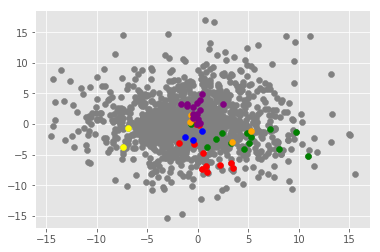

In [0]:
import mplcursors

with plt.style.context('ggplot'):
  fig, ax =plt.subplots()
  plt.scatter(matrix_red[:,0],matrix_red[:,1], color='grey')

#some proteins

  meat_pca=pca.transform(meat_matrix)
  plt.scatter(meat_pca[:,0],meat_pca[:,1],color='red')

#vegetables
  veg_pca=pca.transform(veg_matrix)
  plt.scatter(veg_pca[:,0],veg_pca[:,1],color='green')

#fish
  fish_pca=pca.transform(fish_matrix)
  plt.scatter(fish_pca[:,0],fish_pca[:,1],color='blue')

#carbs
  carb_pca=pca.transform(carb_matrix)
  plt.scatter(carb_pca[:,0],carb_pca[:,1],color='orange')

#tools
  tools_pca=pca.transform(tools_matrix)
  plt.scatter(tools_pca[:,0],tools_pca[:,1],color='yellow')

#fruit
  fruit_pca=pca.transform(fruit_matrix)
  plt.scatter(fruit_pca[:,0],fruit_pca[:,1],color='purple')

mplcursors.cursor(hover=True)

# maybe color proteins, vegetables, cooking tools
#first of all, maybe color just thre recipes


# To do for better visualization
#filter just the cooking ingredients
# either show result of clustering, or feed in a more comprehensive list of items

In [0]:
matrix_red.shape[0]

12233

In [0]:
selection = np.random.choice(matrix_red.shape[0], 5000, replace=False)


'in'

In [0]:
# it's taking too long to plot all the points
# so let's just display a few points

selection = np.random.choice(matrix_red.shape[0], 5000, replace=False)

fig, ax = plt.subplots()
points = ax.scatter(matrix_red[selection,0],matrix_red[selection,1],
                    s=100, alpha=0.3)

labels = [list(model.wv.vocab)[i] for i in selection]
tooltip = plugins.PointLabelTooltip(points, labels)

plugins.connect(fig, tooltip)
mpld3.display()

In [0]:
client = UsdaClient('AHwTWmpP3Qj5dia6lux4vX4e3ybNCw6r9wELd5z7')


In [0]:
proteins=client.search_foods('protein',10)
for _ in range(10):
  food_item=next(proteins)
  print(food_item)

PROTEIN WHOLE GRAIN PROTEIN SNACK, UPC: 722252219114
LUNA, PROTEIN, HIGH PROTEIN BAR, CHOCOLATE CHIP COOKIE DOUGH, UPC: 722252233035
BENEFIT NUTRITION, PROTEIN PLUS, SOY PROTEIN & MULTIGRAIN CEREAL, UPC: 607440123469
SUPREME PROTEIN, ACCELERATE MORNING PROTEIN BAR, STRAWBERRY BANANA, UPC: 639372233107
SUPREME PROTEIN, PROTEIN BAR, PEANUT BUTTER CRUNCH, UPC: 639372021216
SUPREME PROTEIN, PROTEIN BARS, UPC: 639372020202
SUPREME PROTEIN, HIGH PROTEIN BAR, PEANUT BUTTER CRUNCH, UPC: 639372025009
SUPREME PROTEIN, HIGH PROTEIN BAR, CARAMEL NUT CHOCOLATE, UPC: 639372025023
GRILLED WHITE MEAT CHICKEN, HUMMUS, WHITE CHEDDAR CHEESE, CELERY, AND NAAN ROUNDS PROTEIN PACK, EXCELLENT SOURCE OF PROTEIN, UPC: 052548589844
FERMENTED VEGAN PROTEIN+ PROTEIN BAR, UPC: 624777007927


In [0]:
model2.wv.save_word2vec_format('/content/drive/My Drive/data_science/recipes/word2vec_recipe_trained.bin',binary=True)


### How are pretrained word2vec model and the newly trained word2vec model different?

In [0]:
# both embed words into 300 dimensional vectors
# When we search for the most similar vectors to a given word,
# the pretrained model seems to return 'food belonging to that type'
# where as our newly trained model seems to return 'similar alternatives'

# this might simply be because the pretrained model was trained on a much larger
# text, so it's possible that there are just more words in the training set,
# like sirloin, prime rib, tenderloin, etc 

# I think this might be the case, becasue when we look for the top 15 most
# similar words, the words from the pretrained model have higher (closer to 1)
# cosine similarity than the words from the newly trained model 




In [0]:
model.similar_by_word('steak',topn=15,restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('steaks', 0.7335855960845947),
 ('mediumrare', 0.6318039894104004),
 ('grain', 0.62589430809021),
 ('skirt', 0.5801817774772644),
 ('chops', 0.5784642696380615),
 ('tuna', 0.5364434719085693),
 ('rare', 0.5084277391433716),
 ('flank', 0.4908929765224457),
 ('lamb', 0.4829716980457306),
 ('doneness', 0.47728121280670166),
 ('board', 0.4552207291126251),
 ('chimichurri', 0.4465738534927368),
 ('thinly', 0.43752047419548035),
 ('pork', 0.43546849489212036),
 ('beef', 0.43059900403022766)]

In [0]:
model2.wv.similar_by_word('steak',topn=15,restrict_vocab=None)

In [0]:
model.similar_by_word('salad',topn=15,restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dressing', 0.7964476346969604),
 ('vinaigrette', 0.7478728890419006),
 ('watercress', 0.7443512082099915),
 ('frisée', 0.7312421798706055),
 ('arugula', 0.7281455993652344),
 ('slaw', 0.7227060794830322),
 ('lettuce', 0.7075955867767334),
 ('radishes', 0.7064037322998047),
 ('salads', 0.7013168334960938),
 ('romaine', 0.6958824396133423),
 ('lettuces', 0.6395835876464844),
 ('avocado', 0.6316620707511902),
 ('jicama', 0.6269614100456238),
 ('endive', 0.6230140924453735),
 ('radicchio', 0.6111922264099121)]

In [0]:
model2.wv.most_similar('chicken',topn=15,restrict_vocab=None)

In [0]:
# this is implying that maybe we need to convert all plurals in to singulars

In [0]:
# What vegetable should I eat with lamb? or chicken? 
# asparagus is to steak as X is to chicken
#  vec(steak) -vec(asparagus)= vec(chicken) - vec(X)
# vec(X) = vec(chicken) + vec(asparagus)-vec(steak)

model2.similar_by_vector(model2['chicken']+model2['asparagus']-model2['steak'],topn=15,restrict_vocab=None)



In [0]:
model.similar_by_vector(model['lamb']+model['vegetable']-model['steak'],topn=15,restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('vegetable', 0.5379717350006104),
 ('lamb', 0.5354306101799011),
 ('olive', 0.3948507606983185),
 ('shanks', 0.37691861391067505),
 ('parsnip', 0.37365537881851196),
 ('potato', 0.3590221405029297),
 ('squash', 0.35643401741981506),
 ('breadcrumb', 0.3527926802635193),
 ('casserole', 0.3448244333267212),
 ('depth', 0.3374180495738983),
 ('rosemary', 0.33438974618911743),
 ('herb', 0.3278125822544098),
 ('oxtail', 0.31896311044692993),
 ('butternut', 0.31194695830345154),
 ('cuminsalt', 0.30853623151779175)]

In [0]:
model.similar_by_vector(model['bacon'], topn= 15, restrict_vocab = None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bacon', 1.0),
 ('pancetta', 0.7798669338226318),
 ('crisp', 0.6605666875839233),
 ('rendered', 0.6293946504592896),
 ('chorizo', 0.5797315835952759),
 ('sausage', 0.5407482385635376),
 ('sausages', 0.5224363803863525),
 ('ham', 0.4978555738925934),
 ('fat', 0.47747671604156494),
 ('render', 0.4567064642906189),
 ('drippings', 0.4440554678440094),
 ('renders', 0.43891608715057373),
 ('cracklings', 0.4384816884994507),
 ('towels', 0.4244651794433594),
 ('duck', 0.4054550230503082)]

In [0]:
model2.similar_by_vector(model2['lamb']+model2['asparagus']-model2['steak'],topn=15,restrict_vocab=None)



In [0]:
model.similar_by_vector(model['lamb']+model['asparagus']-model['steak'],topn=15,restrict_vocab=None)
#

# hmm, the pretrained model seems to think that fruit (pears, grape, strawberries)
# should be paired with lamb, while the new model doesn't think so.

#why? 

In [0]:
model.similar_by_word('meat',topn=15,restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('bone', 0.7342758178710938),
 ('bones', 0.7142550349235535),
 ('leg', 0.6270058155059814),
 ('brisket', 0.5727496147155762),
 ('beef', 0.5679225921630859),
 ('loin', 0.5629754066467285),
 ('shoulder', 0.5611631274223328),
 ('marrow', 0.5462486743927002),
 ('duck', 0.5382863879203796),
 ('thigh', 0.5329949259757996),
 ('thickest', 0.5275232195854187),
 ('tail', 0.5267216563224792),
 ('part', 0.5200143456459045),
 ('veal', 0.5152628421783447),
 ('octopus', 0.5118818283081055)]

In [0]:
# Given an ingredient, say "lamb", can I return ingredients that pairs well with lamb?
# for example, find a nearby word that belongs in "vegetables"
# find a nearaby word that belongs in "wine"
# how to check if a word belongs to paraticular categories?

# For example, return vegetables, wine that pair well with lamb
# Or would this be eaasier to do just from counting the number of word pairs with lamb? 

In [0]:

ing = eval(df.at[1,'ingredients'])
for item in ing:
  print(item)
  # get rid of numbers (4 cups, 2 tablespoon)
  item = re.sub('[0-9]+','',item)

  # remove special characters
  item = re.sub('/|,|\(|\)','',item)

  item = item.lower()
  print(item)

1 1/2 cups whipping cream
  cups whipping cream
2 medium onions, chopped
 medium onions chopped
5 teaspoons salt
 teaspoons salt
3 bay leaves
 bay leaves
3 whole cloves
 whole cloves
1 large garlic clove, crushed
 large garlic clove crushed
1 teaspoon pepper
 teaspoon pepper
1/8 teaspoon ground nutmeg
 teaspoon ground nutmeg
Pinch of dried thyme, crumbled
pinch of dried thyme crumbled
8 large shallots, minced
 large shallots minced
1 tablespoon butter
 tablespoon butter
1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled
 pound trimmed boneless center pork loin sinew removed cut into -inch chunks well chilled
3 eggs
 eggs
6 tablespoon all purpose flour
 tablespoon all purpose flour
1/4 cup tawny Port
 cup tawny port
3 tablespoons dried currants, minced
 tablespoons dried currants minced
Lettuce leaves
lettuce leaves
Cracked peppercorns
cracked peppercorns
Minced fresh parsley
minced fresh parsley
Bay leaves
bay leaves
French bread baguette slic

In [0]:
# cluster using only the ingredients
# find all words appearing in the ingredients
# create a giant list of all words that appear in "ingredients"
ingredients = []

for index in df.index:
  ing = eval(df.at[index,'ingredients'])
  ing_cleaned = []
  for item in ing:
    # get rid of numbers (4 cups, 2 tablespoon)
    item = re.sub('[0-9]+','',item)

    # remove special characters
    item = re.sub('/|,|\(|\)','',item)

    item = item.lower()

    ing_cleaned.append(item)
  df.at[index,'ingredients'] = ing_cleaned

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-258-1a97bed645fc>", line 4, in <module>
    ing = eval(df.at[index,'ingredients'])
TypeError: eval() arg 1 must be a string, bytes or code object

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/lib/python3.

TypeError: ignored

In [0]:
ingredients = []
for index in df.index:
  ing = df.at[index,'ingredients']
  for item in ing:
    ingredients += item.split()

In [0]:
ingredients = list(set(ingredients))

In [0]:
len(ingredients)

9399

In [0]:
# from the embedded words, find only the words that appear as ingredients
ing_list = [idx for idx, item in enumerate(list(model.wv.vocab.keys())) if item in ingredients]


In [0]:
ing_embed = embedding_matrix[ing_list,:]

In [0]:
ing_embed.shape

(4335, 300)

In [0]:
# Can I use "clusters"? As a way to tell if ingredient belongs in a particualr group? 
np.savetxt(directory + '/embeddeding.csv', embedding_matrix.T)


In [0]:
embedding_matrix.shape

(12233, 300)

In [0]:
# do a regular clustering


from sklearn.cluster import DBSCAN

In [0]:
clu = DBSCAN(eps = 1)
labels = clu.fit_predict(embedding_matrix)

In [0]:
np.unique(labels)

array([-1,  0])

In [0]:
from sklearn.cluster import AgglomerativeClustering


In [0]:
clu = AgglomerativeClustering(n_clusters = 9)
labels = clu.fit_predict(embedding_matrix)

In [0]:
# find exmaple words in clusters 
label1 = np.argwhere(labels == 9)
count = 0
while count <= 100 and count < len(label1):
  print(list(model.wv.vocab.keys())[label1[count][0]])
  count += 1



In [0]:
# label 0: seems to be associated with baking
# label 1: words for cooking technique
# label 2: words associated with meat cooking
# label 3: units (inch, cup, hours,)
# label 4: technique
# label 5: vegetable and spices
# label 6: measure (high, low, ...)
# label 7: numbers
# label 8: not sure


226

In [0]:
embedding_matrix.shape

(12233, 300)

In [0]:
np.squeeze(embedding_matrix[label_2,:]).shape

(468, 300)

In [0]:
# take label 0, 2, 5. Cluster again
label_2 = np.argwhere(labels == 2)
clu = AgglomerativeClustering(n_clusters = 9)
label_2_new = clu.fit_predict(np.squeeze(embedding_matrix[label_2,:]))


In [0]:

label_2[label1[5][0]]

array([72])

In [0]:
# find example words in clusters 
label1 = np.argwhere(label_2_new == 6)
count = 0
while count <= 50 and count < len(label1):
  print(list(model.wv.vocab.keys())[label_2[label1[count][0]][0]])
  count += 1


heat
oil
heavy
melt
batches
brown
bacon
crisp
towels
working
smoking
browned
nonstick
moderately
fat
batch
fry
repeat
melted
golden
same
manner


In [0]:
'boil' in ingredients

True

In [0]:
from sklearn.metrics import silhouette_score

In [0]:
# finding the right number of clusters
num_clusters =range(2,25)
silhouette_scores = []
n_samples = embedding_matrix.shape[0]
for k in num_clusters:

    clu = AgglomerativeClustering(n_clusters = k)
    labels = clu.fit_predict(ing_embed)
    
    # compute silhouette score
    s_score = silhouette_score(ing_embed, labels)
    silhouette_scores.append(s_score)

print(silhouette_scores)

[0.5783494538990019, 0.581604852057221, 0.5871719558602999, 0.5827401742891372, 0.5472033558469911, 0.5488224571307807, 0.5496684605671065, 0.5000214140499395, 0.5003599276864888, 0.5079868678577987, 0.5024440908416157, 0.5034721618946485, 0.5037500769603914, 0.5049802081949788, 0.5057008916037111, 0.5061264635401729, 0.49748716534448434, 0.4981737361731633, 0.49861300137231174, 0.49956188781079575, 0.4998734901205956, 0.5000935440903092, 0.5005218001738128]


In [0]:
# finding the right number of clusters
num_clusters =range(25,50)
silhouette_scores = []
n_samples = embedding_matrix.shape[0]
for k in num_clusters:

    clu = AgglomerativeClustering(n_clusters = k)
    labels = clu.fit_predict(embedding_matrix)
    
    # compute silhouette score
    s_score = silhouette_score(embedding_matrix, labels)
    silhouette_scores.append(s_score)

print(silhouette_scores)

[0.7509306441847945, 0.7510560138912189, 0.7512344679617065, 0.739995039761559, 0.7401990095771548, 0.740452870411332, 0.7086287025044441, 0.7086958655569305, 0.7088272520433807, 0.7091220400008496, 0.7091953412362909, 0.7094398138231689, 0.7099380906805234, 0.7100379367395516, 0.7104678756286539, 0.7107541301989179, 0.710803486137141, 0.7109895154412273, 0.7110488013908682, 0.7083589943146947, 0.708388334537034, 0.7084233045832845, 0.7089610642529278, 0.7090004569412472, 0.709111972411303]


In [0]:
#  kmeans clustering
clu = KMeans(n_clusters = 9)
labels = clu.fit_predict(ing_embed)

In [0]:
# find exmaple words in clusters 
label1 = np.argwhere(labels == 8)
count = 0
while count <= 50 and count < len(label1):
  print(list(model.wv.vocab.keys())[label1[count][0]])
  count += 1


combined
prepared
teaspoons
sesame


In [0]:
# finding the right number of clusters
num_clusters =range(1,20)
silhouette_scores = []
n_samples = embedding_matrix.shape[0]
for k in num_clusters:
    print(k)

    clu = KMeans(n_clusters = k)
    labels = clu.fit_predict(embedding_matrix)
    
    # compute silhouette score
    s_score = silhouette_score(embedding_matrix, labels)
    silhouette_scores.append(s_score)

print(silhouette_scores)

1


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-197-cae1d733923c>", line 11, in <module>
    s_score = silhouette_score(embedding_matrix, labels)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/_unsupervised.py", line 117, in silhouette_score
    return np.mean(silhouette_samples(X, labels, metric=metric, **kwds))
  File "/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/_unsupervised.py", line 228, in silhouette_samples
    check_number_of_labels(len(le.classes_), n_samples)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/_unsupervised.py", line 35, in check_number_of_labels
    "to n_samples - 1 (inclusive)" % n_labels)
ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

During handling of the above exception, another exception 

ValueError: ignored